In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 4)

import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [4]:
#Rob: toggle flags
apply_standardization = True
apply_transform = False

## Load and Concatenate

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  

[2 rows x 81 columns]

In [7]:
train.shape

(1460, 81)

In [8]:
test.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  

[2 rows x 80 columns]

In [9]:
test.shape

(1459, 80)

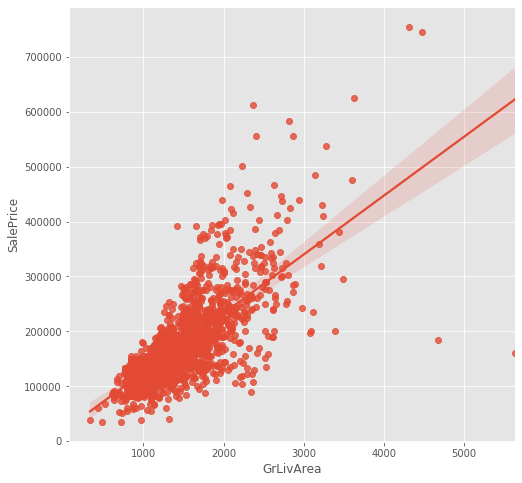

In [10]:
# Very first visual check -- SalePrice ~ GrLivArea
plt.figure(figsize=(8,8))
sns.regplot(x=train.GrLivArea, y=train.SalePrice, data=train)

In [11]:
# remove outliers with GrLivArea > 4_000 sqf
#Rob: revisit these 4 outliers once model pipeline is complete
train = train[train.GrLivArea < 4_000]

In [12]:
# TARGET VARIABLE
SalePrice = train.pop('SalePrice')

In [13]:
df = pd.concat([train, test], axis=0)
df.shape

(2915, 80)

In [14]:
df.describe().T

count        mean        std     min     25%     50%  \
Id             2915.0   1460.7348   843.0458     1.0   731.5  1462.0   
MSSubClass     2915.0     57.1338    42.5467    20.0    20.0    50.0   
LotFrontage    2429.0     69.1289    22.7154    21.0    59.0    68.0   
LotArea        2915.0  10133.6487  7806.1985  1300.0  7474.0  9450.0   
OverallQual    2915.0      6.0837     1.4034     1.0     5.0     6.0   
OverallCond    2915.0      5.5650     1.1137     1.0     5.0     5.0   
YearBuilt      2915.0   1971.2717    30.2910  1872.0  1953.0  1973.0   
YearRemodAdd   2915.0   1984.2405    20.8973  1950.0  1965.0  1993.0   
MasVnrArea     2892.0    101.3994   177.4529     0.0     0.0     0.0   
BsmtFinSF1     2914.0    438.0981   442.8721     0.0     0.0   368.0   
BsmtFinSF2     2914.0     49.6503   169.3118     0.0     0.0     0.0   
BsmtUnfSF      2914.0    560.6383   439.7044     0.0   220.0   467.0   
TotalBsmtSF    2914.0   1048.3868   427.7466     0.0   793.0   988.0   
1stFlrSF       2915.0   1156.8213   383.9568   334.0   876.0  1082.0   
2ndFlrSF       2915.0    334.7413   426.1164     0.0     0.0     0.0   
LowQualFinSF   2915.0      4.7009    46.4283     0.0     0.0     0.0   
GrLivArea      2915.0   1496.2635   491.2394   334.0  1125.5  1442.0   
BsmtFullBath   2913.0      0.4291     0.5240     0.0     0.0     0.0   
BsmtHalfBath   2913.0      0.0611     0.2452     0.0     0.0     0.0   
FullBath       2915.0      1.5664     0.5514     0.0     1.0     2.0   
HalfBath       2915.0      0.3794     0.5027     0.0     0.0     0.0   
BedroomAbvGr   2915.0      2.8593     0.8227     0.0     2.0     3.0   
KitchenAbvGr   2915.0      1.0446     0.2146     0.0     1.0     1.0   
TotRmsAbvGrd   2915.0      6.4456     1.5620     2.0     5.0     6.0   
Fireplaces     2915.0      0.5952     0.6439     0.0     0.0     1.0   
GarageYrBlt    2756.0   1978.0798    25.5765  1895.0  1960.0  1979.0   
GarageCars     2914.0      1.7653     0.7611     0.0     1.0     2.0   
GarageArea     2914.0    472.1692   214.4982     0.0   320.0   479.5   
WoodDeckSF     2915.0     93.5039   126.4551     0.0     0.0     0.0   
OpenPorchSF    2915.0     47.2686    67.1396     0.0     0.0    26.0   
EnclosedPorch  2915.0     23.1300    64.2826     0.0     0.0     0.0   
3SsnPorch      2915.0      2.6058    25.2053     0.0     0.0     0.0   
ScreenPorch    2915.0     16.0844    56.2198     0.0     0.0     0.0   
PoolArea       2915.0      1.8998    33.0206     0.0     0.0     0.0   
MiscVal        2915.0     50.8957   567.7884     0.0     0.0     0.0   
MoSold         2915.0      6.2151     2.7122     1.0     4.0     6.0   
YrSold         2915.0   2007.7935     1.3156  2006.0  2007.0  2008.0   

                    75%       max  
Id              2190.50    2919.0  
MSSubClass        70.00     190.0  
LotFrontage       80.00     313.0  
LotArea        11554.50  215245.0  
OverallQual        7.00      10.0  
OverallCond        6.00       9.0  
YearBuilt       2001.00    2010.0  
YearRemodAdd    2004.00    2010.0  
MasVnrArea       164.00    1600.0  
BsmtFinSF1       732.00    4010.0  
BsmtFinSF2         0.00    1526.0  
BsmtUnfSF        803.75    2336.0  
TotalBsmtSF     1300.00    5095.0  
1stFlrSF        1383.50    5095.0  
2ndFlrSF         703.50    1862.0  
LowQualFinSF       0.00    1064.0  
GrLivArea       1742.50    5095.0  
BsmtFullBath       1.00       3.0  
BsmtHalfBath       0.00       2.0  
FullBath           2.00       4.0  
HalfBath           1.00       2.0  
BedroomAbvGr       3.00       8.0  
KitchenAbvGr       1.00       3.0  
TotRmsAbvGrd       7.00      15.0  
Fireplaces         1.00       4.0  
GarageYrBlt     2002.00    2207.0  
GarageCars         2.00       5.0  
GarageArea       576.00    1488.0  
WoodDeckSF       168.00    1424.0  
OpenPorchSF       70.00     742.0  
EnclosedPorch      0.00    1012.0  
3SsnPorch          0.00     508.0  
ScreenPorch        0.00     576.0  
PoolArea           0.00     800.0  
MiscVal            

## Divide by data type

In [15]:
# drop Id
df.drop(['Id'], axis=1, inplace=True)

In [16]:
cat_features = list(df.select_dtypes(include=['object']).columns)
print(f'Object types:  {len(cat_features)}')
print(cat_features)

Object types:  43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [17]:
num_features = list(df.select_dtypes(include=['int64','float64']).columns)
print(f'Numeric types:  {len(num_features)}')
print(num_features)

Numeric types:  36
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [18]:
# Some numeric features are categorical and ordinal, 
# leave the numerical values (potentially intact) but reclassify to categorical
cat_features += ['OverallQual', 'OverallCond']

# Some numeric features are categorical by nature and NOT ordinal: replace with string
df['MSSubClass'] = df.MSSubClass.apply(lambda x: str(x))
df['MoSold'] = df.MoSold.apply(lambda x: str(x))
df['YrSold'] = df.YrSold.apply(lambda x: str(x))

cat_features += ['MSSubClass', 'MoSold', 'YrSold']

print(f'Object types:  {len(cat_features)}')

Object types:  48


In [19]:
# Remove newly classified categoricals from numeric
num_features = [f for f in num_features if f not in cat_features] 
print(f'Numeric types:  {len(num_features)}')

Numeric types:  31


In [20]:
print(cat_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallQual', 'OverallCond', 'MSSubClass', 'MoSold', 'YrSold']


In [21]:
print(num_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


## Classify Ordinal vs. Nominal

By default, all categorical features are nominal.  The following are classified ordinal:
- levels are clearly ordered (e.g. Functional, LandSlope, LotShape). This is regardless of the feature's correlation with price, e.g. may be completely uncorrelated. 
- if we __suspect__ order, verify by a boxplot Price~Feature (e.g. 'MSSubClass'). Classify as ordinal only if there is visual correlation with sorted levels

In [22]:
cat_ordinal = [  # definitely ordinal
'Street',
'Alley',
'LotShape',
'Utilities',
'LandSlope',
'ExterQual',
'ExterCond',
'BsmtQual',
'BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinType2',
'HeatingQC',
'CentralAir',
'KitchenQual',
'Functional',
'FireplaceQu',
'GarageFinish',
'GarageQual',
'GarageCond',
'PavedDrive',
'PoolQC',
'Fence',    
]
print(f'Definitely ordinal:  {len(cat_ordinal)}')

Definitely ordinal:  23


In [23]:
cat_ordinal_candidates = [ # potentially ordinal
'MSSubClass',
'LandContour',
'LotConfig',
'BldgType',    
'HouseStyle',    
'Foundation',
'Electrical',
'SaleType',
'SaleCondition',
]
print(f'Potentially ordinal:  {len(cat_ordinal_candidates)}')

Potentially ordinal:  9


In [24]:
cat_nominal = [f for f in cat_features if f not in cat_ordinal and f not in cat_ordinal_candidates] 
print(f'Definitely nominal:  {len(cat_nominal)}')
cat_nominal

Definitely nominal:  16


['MSZoning',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Heating',
 'GarageType',
 'MiscFeature',
 'OverallQual',
 'OverallCond',
 'MoSold',
 'YrSold']

In [25]:
# We care about display order for the candidate ordinals:
#Rob: added VWD to SaleType, removed comma after SaleCondition 
display_order = {
'MSSubClass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '160', '180', '190'],
'LandContour': ['Lvl','Bnk', 'HLS', 'Low'],
'LotConfig': ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'],
'BldgType':    ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'],
'HouseStyle':  ['1Story', '1.5Unf', '1.5Fin', '2Story', '2.5Unf', '2.5Fin', 'SFoyer', 'SLvl'],    
'Foundation': ['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'],
'Electrical': ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'],
'SaleType': ['WD','CWD','New','COD','Con','ConLw','ConLI','ConLD','Oth','VWD'],
'SaleCondition': ['Normal','Abnorml','AdjLand','Alloca','Family','Partial']
}

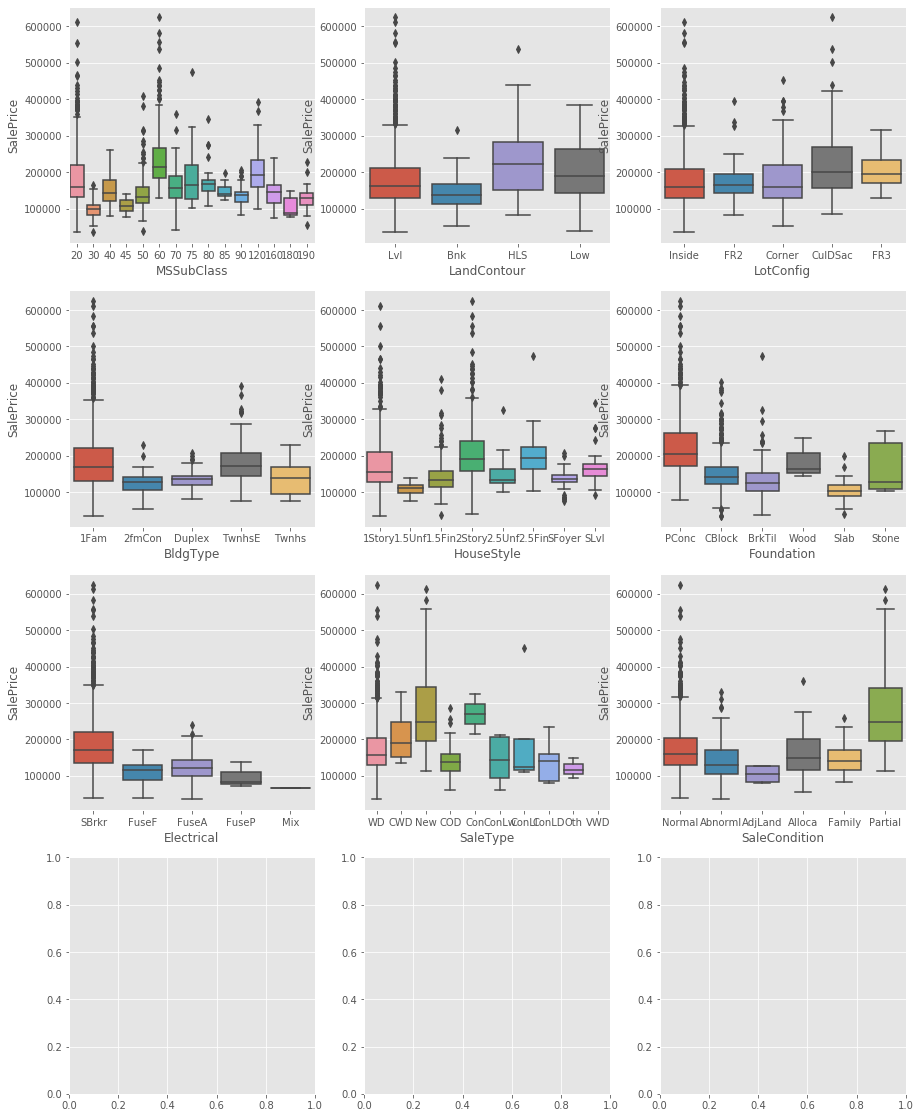

In [26]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(SalePrice),:], SalePrice], axis=1)

# plt.subplots(nrows, ncols, figsize=(width, height))
nc  = 3
nr  = 1+len(cat_ordinal_candidates)//nc
f,axes = plt.subplots(nr, nc, figsize=(nc*5, nr*5))

counter = 0
for f in cat_ordinal_candidates:
    sns.boxplot(f, 'SalePrice', data=train_processed, order=display_order[f], 
                ax = axes[counter//nc][counter%nc])
    counter+=1

Conclusion: there is no internal order that would cause a visible correlation with the Price. 
All candidate features should be classified as nominal. 

In [27]:
cat_nominal = cat_nominal + cat_ordinal_candidates
cat_nominal = list(set(cat_nominal))
cat_ordinal = list(set(cat_ordinal))

print(f'Nominal features:  {len(cat_nominal)}')
print(f'Ordinal features:  {len(cat_ordinal)}')

Nominal features:  25
Ordinal features:  23


## Neighborhoods

In [28]:
display_order = train_processed.groupby(['Neighborhood']).mean()['SalePrice']
display_order = display_order.sort_values(ascending=True).index.to_list()

In [29]:
counts = train_processed.groupby(['Neighborhood']).count().iloc[:,0].reindex(display_order)

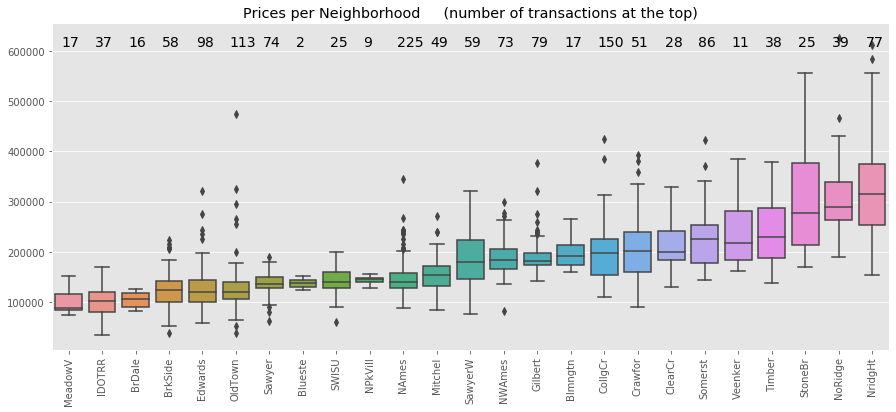

In [30]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(x="Neighborhood", y="SalePrice", data=train_processed, order=display_order)

h_offset = -0.2
v_level = 610_000
for i, count in enumerate(counts):
    ax.text(i+h_offset, v_level, str(count), fontsize=14)

plt.xticks(rotation=90)
plt.title('Prices per Neighborhood     (number of transactions at the top)')
plt.ylabel('')
plt.xlabel('')
plt.show()

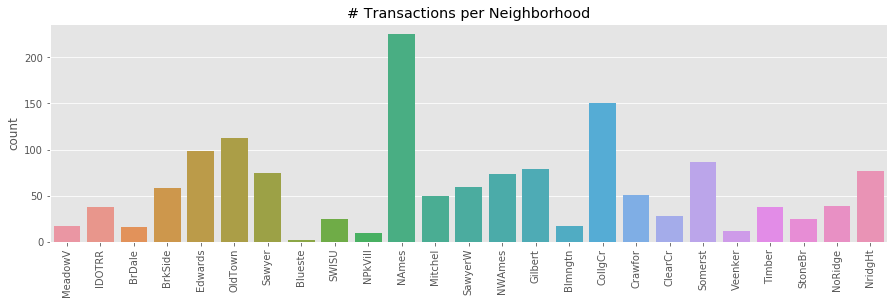

In [31]:
plt.figure(figsize=(15,4))
sns.countplot("Neighborhood", data=train_processed, order=display_order)
plt.xticks(rotation=90)
plt.title('# Transactions per Neighborhood')
plt.xlabel('')
plt.show()

In [32]:
train_processed['YrMoSold'] = train_processed.apply(lambda row: row['YrSold']+'_'+row['MoSold'], axis=1)

In [33]:
def ym_string(row):
    y = row['YrSold']
    m = row['MoSold'] if len(row['MoSold'])==2 else '0'+row['MoSold']
    return y+'_'+m

In [34]:
train_processed['YrMoSold'] = train_processed.apply(ym_string, axis=1)

In [35]:
train_processed['YrMoSold']

0       2008_02
1       2007_05
2       2008_09
3       2006_02
4       2008_12
         ...   
1455    2007_08
1456    2010_02
1457    2010_05
1458    2010_04
1459    2008_06
Name: YrMoSold, Length: 1456, dtype: object

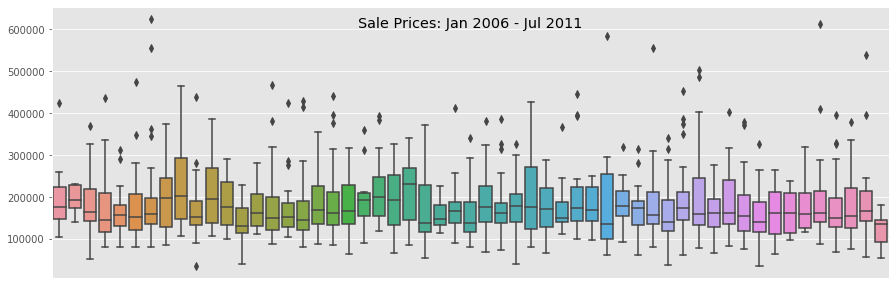

In [36]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="YrMoSold", y="SalePrice", data=train_processed)
# ax.set_title('Sale Prices: Jan 2006 - Jul 2011')
plt.title('Sale Prices: Jan 2006 - Jul 2011', x=0.5, y=0.9)
# plt.xticks(rotation=90)
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.show()

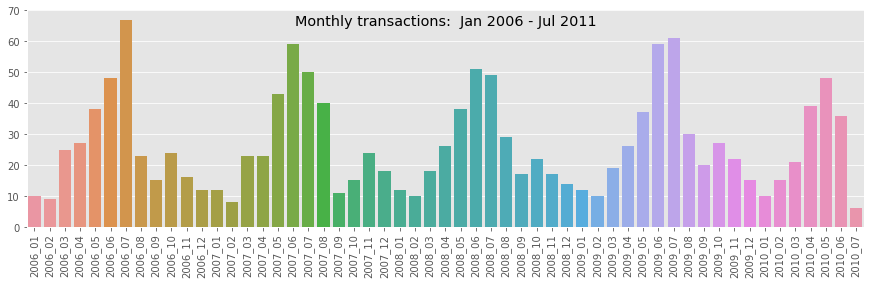

In [37]:
plt.figure(figsize=(15,4))
ax = sns.countplot("YrMoSold", data=train_processed)
plt.title('Monthly transactions:  Jan 2006 - Jul 2011', x=0.5, y=0.9)
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.show()

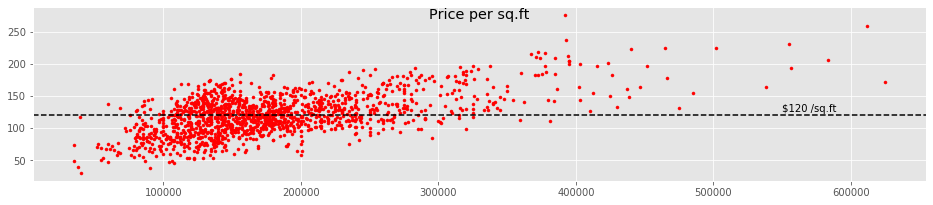

In [38]:
plt.figure(figsize=(16,3.2))

plt.scatter(SalePrice, SalePrice/train.GrLivArea, marker='.', color='r')
plt.axhline(np.mean(SalePrice/train.GrLivArea), color='k', ls='--')
                
plt.title('Price per sq.ft', x=0.5, y=0.9)
# plt.xticks(rotation=90)
# plt.ylabel('')
plt.text(550_000, 125, '$120 /sq.ft')
plt.show()                
                

In [39]:
np.mean(SalePrice/train.GrLivArea)

120.62304892833228

Nominal categorical will only be dummified, ordinals remain intact (possibly rescaling)

## Categorical features: Impute nan

Verify each categorical feature to apply the following approach:
- nominal features: replace nan with string 'None' unless has specific meaning
- ordinal features: replace nan with 0 unless nan means something else. Nan typically means the absence of the feature such as 'no garage'.  Later, map the remaining levels to 1,2,..

In [40]:
for f in cat_nominal:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

1   nans in   SaleType
24   nans in   MasVnrType
4   nans in   MSZoning
157   nans in   GarageType
1   nans in   Exterior2nd
1   nans in   Electrical
2810   nans in   MiscFeature
1   nans in   Exterior1st


In [41]:
for f in cat_ordinal:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

1420   nans in   FireplaceQu
2   nans in   Utilities
2345   nans in   Fence
82   nans in   BsmtCond
159   nans in   GarageCond
159   nans in   GarageFinish
1   nans in   KitchenQual
2907   nans in   PoolQC
82   nans in   BsmtExposure
2   nans in   Functional
81   nans in   BsmtQual
159   nans in   GarageQual
80   nans in   BsmtFinType2
79   nans in   BsmtFinType1
2717   nans in   Alley


Checked all missing columns, the default approach of replacing with 'None' and 0 should work

In [42]:
for f in cat_nominal:
    df[f].fillna('None', inplace=True)

In [43]:
for f in cat_ordinal:
    df[f].fillna(0, inplace=True)

## Map Ordinal to numeric

In [44]:
# NB map the FULL dictionary from the description b/c some labels may appear only in the test set
# still, check unique levels for all ordinals in the train set
{f: list(train[f].unique()) for f in cat_ordinal}

{'FireplaceQu': [nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'Utilities': ['AllPub', 'NoSeWa'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'CentralAir': ['Y', 'N'],
 'Fence': [nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'],
 'BsmtCond': ['TA', 'Gd', nan, 'Fa', 'Po'],
 'GarageCond': ['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'],
 'GarageFinish': ['RFn', 'Unf', 'Fin', nan],
 'KitchenQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'PoolQC': [nan, 'Ex', 'Fa', 'Gd'],
 'BsmtExposure': ['No', 'Gd', 'Mn', 'Av', nan],
 'PavedDrive': ['Y', 'N', 'P'],
 'LandSlope': ['Gtl', 'Mod', 'Sev'],
 'Functional': ['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'],
 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
 'BsmtQual': ['Gd', 'TA', 'Ex', nan, 'Fa'],
 'GarageQual': ['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'],
 'Street': ['Pave', 'Grvl'],
 'BsmtFinType2': ['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'],
 'Alley': [nan, 'Grvl', 'Pave'],
 '

In [45]:
# Mapping convention: higher levels ~ higher price (NOT always applicable, e.g. LotShape)
# arbitrary convention for the sake of interpretation consistency, should not affect any ML
ordinal_to_numeric = {
    'Street': {'Grvl':1, 'Pave':2},
    'Alley': {'Grvl':1, 'Pave':2},
    'LotShape': {'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4},
    'Utilities': {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4},
    'LandSlope': {'Gtl':1, 'Mod':2, 'Sev':3}, #Rob: order reversed? shouldn't affect anything but the interpretation
    'Fence':{'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}, #Rob: added per Sam's analysis

    'ExterQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'ExterCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'BsmtQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtExposure': {'No':1, 'Mn':2, 'Av':3, 'Gd':4},
    'BsmtFinType1': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
    'BsmtFinType2': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},

    'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'CentralAir': {'N':0, 'Y':1},
    'KitchenQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    # bigger step for 'Typical' - #Rob: why use a larger step between Min1 and Typ?
    'Functional': {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':10},  
    'FireplaceQu': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'GarageFinish': {'Unf':1, 'RFn':2, 'Fin':3},
    'GarageQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'PavedDrive': {'N':1, 'P':2, 'Y':3},
    'PoolQC': {'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
}

In [46]:
for f in ordinal_to_numeric:
    df[f].replace(ordinal_to_numeric[f], inplace=True)

In [47]:
# verify 
df.head(5)

MSSubClass MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0         60       RL         65.0     8450       2      0         1   
1         20       RL         80.0     9600       2      0         1   
2         60       RL         68.0    11250       2      0         2   
3         70       RL         60.0     9550       2      0         2   
4         60       RL         84.0    14260       2      0         2   

  LandContour  Utilities LotConfig  ...  ScreenPorch PoolArea PoolQC Fence  \
0         Lvl          4    Inside  ...            0        0      0     0   
1         Lvl          4       FR2  ...            0        0      0     0   
2         Lvl          4    Inside  ...            0        0      0     0   
3         Lvl          4    Corner  ...            0        0      0     0   
4         Lvl          4       FR2  ...            0        0      0     0   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0        None       0       2    2008        WD         Normal  
1        None       0       5    2007        WD         Normal  
2        None       0       9    2008        WD         Normal  
3        None       0       2    2006        WD        Abnorml  
4        None       0      12    2008        WD         Normal  

[5 rows x 79 columns]

## Adding new Boolean features

In [48]:
# Booleans
df['_Basement'] = df.TotalBsmtSF>0
df['_Garage'] = df.GarageArea>0
df['_Pool'] = df.PoolArea>0
df['_Fence'] = df.Fence!=0  #Rob: Fence is now an ordinal so check for 0 instead of None
# combine 4 types of porches
df['_Porch'] = df.OpenPorchSF+df.EnclosedPorch+df['3SsnPorch']+df.ScreenPorch > 0

#Rob:added
df['_MasVnrArea'] = (df.MasVnrType != 'None')
df['_WoodDeck'] = df.WoodDeckSF > 0
df['_MiscFeature'] = (df.MiscFeature!='None')

In [49]:
# More Booleans
#Rob: revisit the bucketing on YearBuilt if there's time
df['_New'] = df.YearBuilt > 2000  #potentially bucketize the entire range
df['_Old'] = df.YearBuilt < 1920 

df['_Remodeled'] = df.YearRemodAdd != df.YearBuilt
df['_NormalSale'] = df.SaleCondition=='Normal'
df['_AfterWW2'] = (df.YearBuilt >= 1946) #Rob: added per Sam's analysis

In [50]:
#Rob: all the boolean features created thus far
new_boolean = ['_Basement', 
               '_Garage', 
               '_Pool', 
               '_Fence', 
               '_Porch',
               '_MasVnrArea',
               '_WoodDeck', 
               '_MiscFeature',
               '_New',
               '_Old', 
               '_Remodeled', 
               '_NormalSale',
               '_AfterWW2']

In [51]:
# convert to int
for f in new_boolean:
    df[f]=df[f].astype(np.int64)

## Clustering: Categorical

In [52]:
# (optionally add TSNE / UMAP)

In [53]:
all_categorical = cat_nominal + cat_ordinal + new_boolean

In [54]:
chisq_table = np.zeros((len(all_categorical), len(all_categorical)))

for i, f1 in enumerate(all_categorical):
    for j, f2 in enumerate(all_categorical):
        tab = pd.crosstab(df[f1], df[f2])
        chisq_table[i,j] = scipy.stats.chi2_contingency(tab)[1]

sort_order = np.argsort(chisq_table.sum(axis=0))
chisq_table = chisq_table[:,sort_order]
chisq_table = chisq_table[sort_order,:]
heatmap_labels = [all_categorical[i] for i in sort_order]

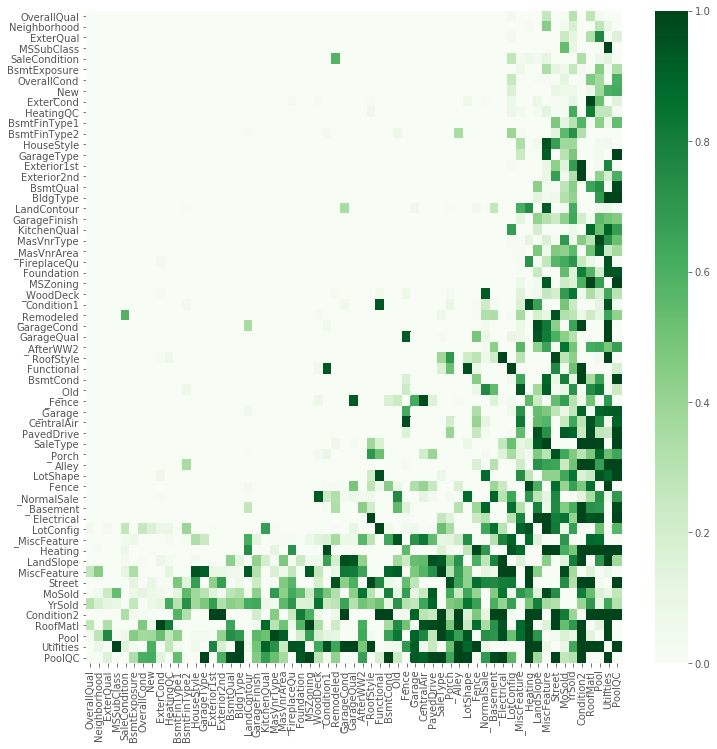

In [55]:
plt.figure(figsize=(12,12))
sns.heatmap(chisq_table, cmap="Greens", xticklabels=heatmap_labels, yticklabels=heatmap_labels)

- The core group of ~10-15 defining characteristics at the top, highly influential (ExterQual, OverallQual, MSSubClass, Neighborhood, New, etc)
- A few categories at the bottom seem to be randomly spread -> candidates for removal

In [56]:
n_tail = 15  #candidates to be removed with n as HP
removal_candidates_0 = heatmap_labels[-n_tail:]
removal_candidates_0

['_Basement',
 'Electrical',
 'LotConfig',
 '_MiscFeature',
 'Heating',
 'LandSlope',
 'MiscFeature',
 'Street',
 'MoSold',
 'YrSold',
 'Condition2',
 'RoofMatl',
 '_Pool',
 'Utilities',
 'PoolQC']

## ANOVA

Verify the clustering intuition with ANOVA LogPrice~Category 

In [57]:
# ANOVA requires that the reponse variables be ~ normal. Log transform the SalePrice.

In [58]:
LogPrice=np.log(SalePrice).rename('LogPrice')

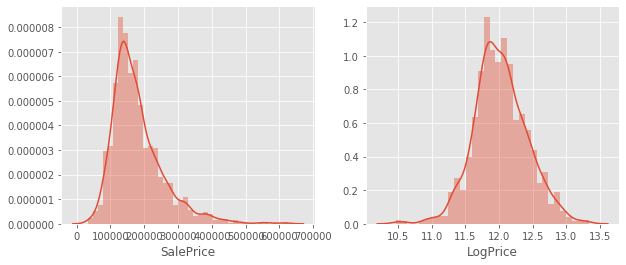

In [59]:
f,axes = plt.subplots(1, 2, figsize=(10, 4))

sns.distplot(SalePrice, ax=axes[0])
sns.distplot(LogPrice, ax=axes[1])

Text(0.5, 1.0, 'After log transform')

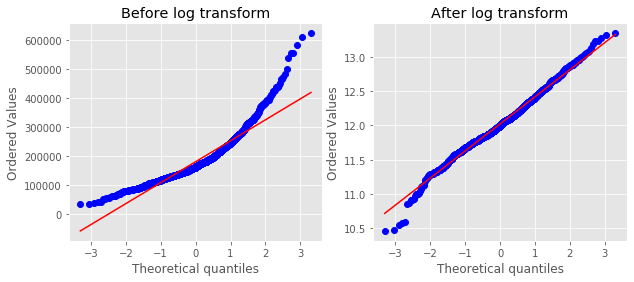

In [60]:
#Rob: put the before and after Q-Q plots side by side for better visuals.
f,axes = plt.subplots(1, 2, figsize=(10, 4))
res1 = stats.probplot(SalePrice, plot=axes[0])
axes[0].set_title("Before log transform")
res2 = stats.probplot(LogPrice, plot=axes[1])
axes[1].set_title("After log transform")

In [61]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

In [62]:
train_processed.head(2)

MSSubClass MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0         60       RL         65.0     8450       2      0         1   
1         20       RL         80.0     9600       2      0         1   

  LandContour  Utilities LotConfig  ...  _Porch _MasVnrArea _WoodDeck  \
0         Lvl          4    Inside  ...       1           1         0   
1         Lvl          4       FR2  ...       0           0         1   

  _MiscFeature _New _Old  _Remodeled  _NormalSale  _AfterWW2  LogPrice  
0            0    1    0           0            1          1   12.2477  
1            0    0    0           0            1          1   12.1090  

[2 rows x 93 columns]

In [63]:
# ANOVA F-statistic with its p-value
F_values, p_values = {},{}

for f in all_categorical:
    group_prices = []
    for group in train_processed[f].unique():
        group_prices.append(train_processed[train_processed[f]==group]['LogPrice'].values)

    F_values[f], p_values[f] = scipy.stats.f_oneway(*group_prices)

In [64]:
F_values = {k:v for k,v in sorted(F_values.items(), key=lambda x: x[1])}
p_values = {k:v for k,v in sorted(p_values.items(), key=lambda x: x[1])}

In [65]:
p_values

{'OverallQual': 0.0,
 'Neighborhood': 7.451511247758564e-242,
 'ExterQual': 5.487175661842523e-196,
 'BsmtQual': 2.3173557817592845e-187,
 'KitchenQual': 5.292077079765444e-186,
 'GarageFinish': 2.7129993153636604e-151,
 'GarageType': 3.8754404716470255e-126,
 'MSSubClass': 1.3207872601320131e-114,
 'FireplaceQu': 1.259783529169019e-113,
 'Foundation': 1.4239979430131833e-111,
 '_New': 1.9683225274080212e-87,
 'HeatingQC': 2.058334264452287e-82,
 'BsmtFinType1': 3.1174290570333098e-77,
 'MasVnrType': 3.061545957996824e-67,
 'MSZoning': 2.8287104898669344e-60,
 'Exterior1st': 3.1629861258661e-56,
 '_MasVnrArea': 1.991342016079393e-54,
 'OverallCond': 5.422658470876797e-54,
 'Exterior2nd': 5.062412545054888e-50,
 'GarageCond': 8.378096673084188e-48,
 '_AfterWW2': 1.1217261332133207e-46,
 'BsmtExposure': 1.864979140868811e-46,
 'GarageQual': 2.0672588008711154e-46,
 'CentralAir': 3.7176103148526634e-44,
 'SaleCondition': 4.115462010677253e-44,
 'SaleType': 1.6088300269571204e-37,
 '_Porch


Possible candiates to remove with p-value >0.05: #Rob: changed p-value threshold to 0.05
- '_Pool'
- 'PoolQC'
- 'LandSlope'
- 'MoSold'
- 'YrSold'
- 'Utilities'

## Classify and Visualize

In [66]:
len(all_categorical)

61

In [67]:
#Rob: added the 3 new boolean features
cat_qual = [
 'OverallQual', 
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Heating',
 'GarageType',
 'MiscFeature',  # mainly shed
 
 'Foundation',
 'Electrical',
 'Fence',
 'Utilities',
 
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',

 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 '_Basement',
 '_Garage',
 '_Pool',
 '_Fence',
 '_Porch',
 '_MasVnrArea',
 '_WoodDeck',
 '_AfterWW2',
 '_MiscFeature'
]

In [68]:
len(cat_qual)

38

In [69]:
# [x for x in all_categorical if x not in elements]

In [70]:
cat_location = [
'MSZoning',
'Neighborhood',
'Condition1',
'Condition2',
]
                
cat_sale = [            
'SaleType',
'SaleCondition',
'_NormalSale',
'MoSold',
'YrSold',
]
    
cat_type = [
'MSSubClass',
'BldgType',
'HouseStyle',
'Functional',
'_Remodeled',
'_Old',
'_New',
]

cat_land = [    
'LotShape',
'LandSlope',
'LandContour',
'LotConfig',
'Street',
'Alley',
'PavedDrive',
]

In [71]:
# verify completeness
assert set(all_categorical)==set(cat_qual+cat_location+cat_sale+cat_type+cat_land)
assert len(all_categorical)==len(cat_qual+cat_location+cat_sale+cat_type+cat_land)


In [72]:
def plot_counts(cat_group, col_wrap=4):
    f = pd.melt(df, value_vars=cat_group)
    g = sns.FacetGrid(f, col='variable', col_wrap=col_wrap, sharex=False, sharey=False)
    g = g.map(sns.countplot, 'value')
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    g.fig.tight_layout()
    plt.show()    

In [73]:
#Rob : disabling the plots of histograms for now as they don't add much information at this point
show_hist = True

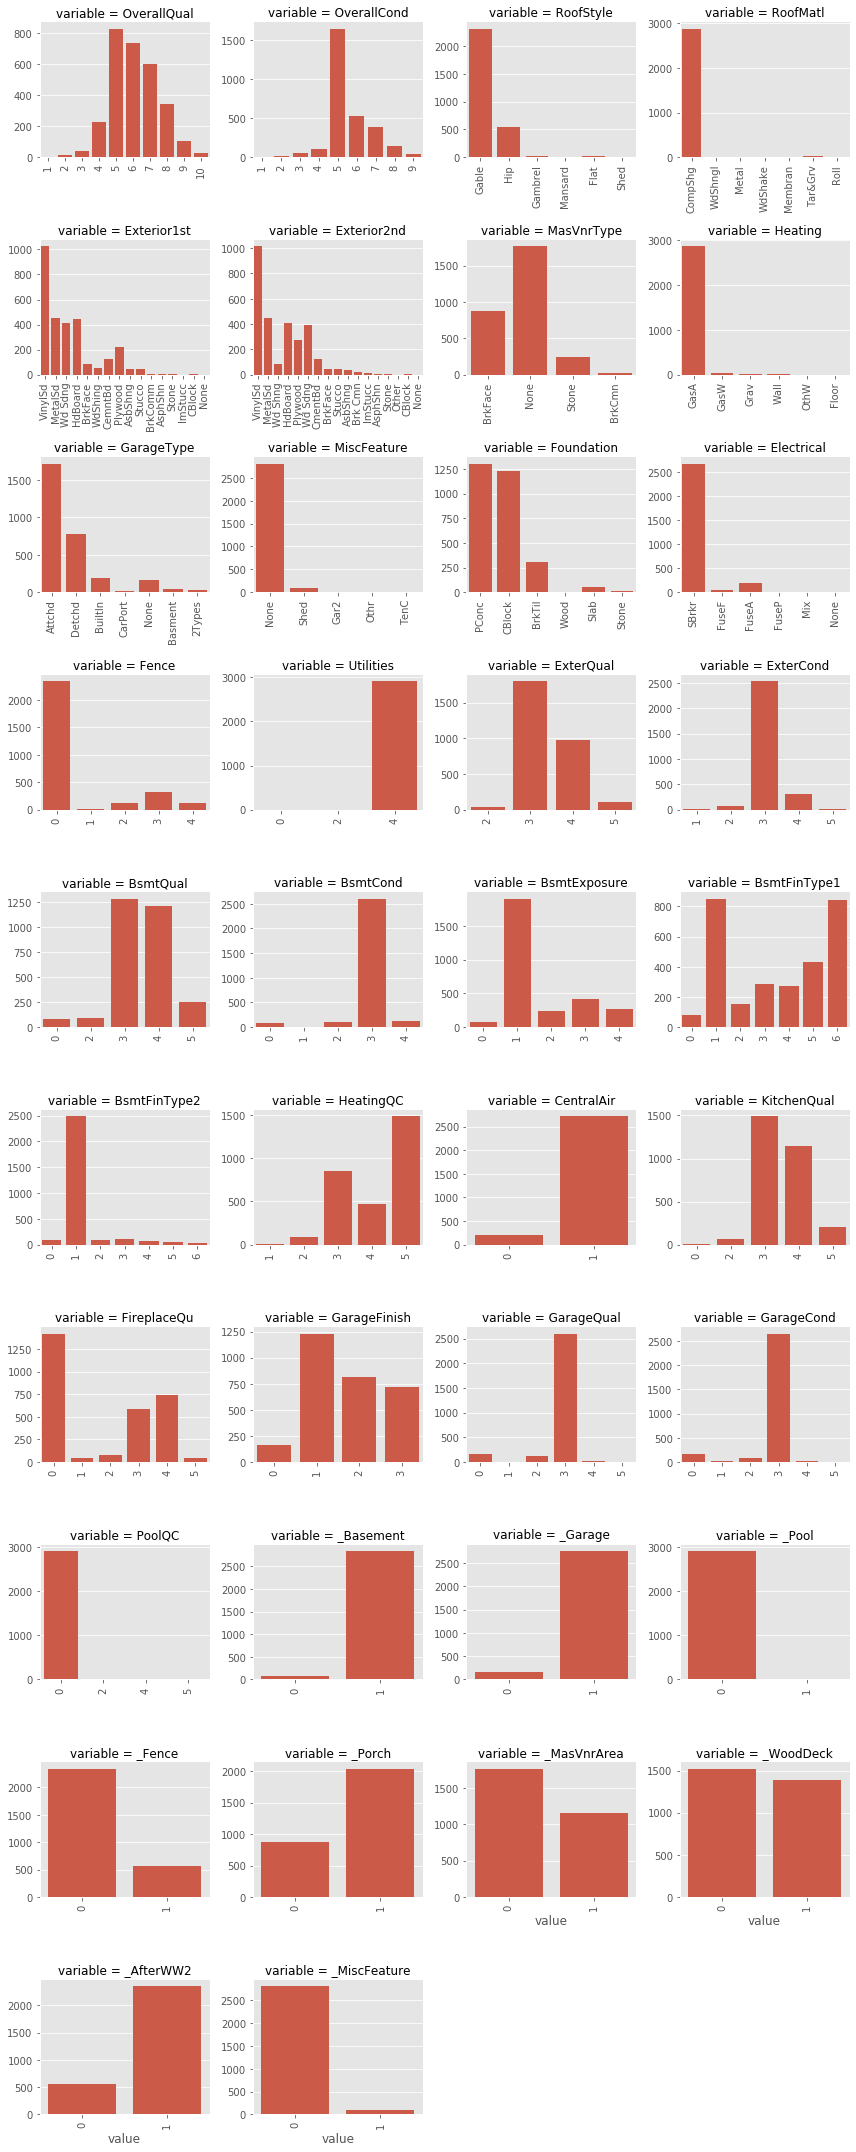

In [74]:
if show_hist:
    plot_counts(cat_qual)

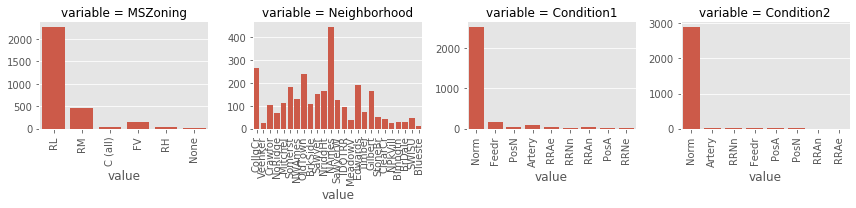

In [75]:
if show_hist:
    plot_counts(cat_location)

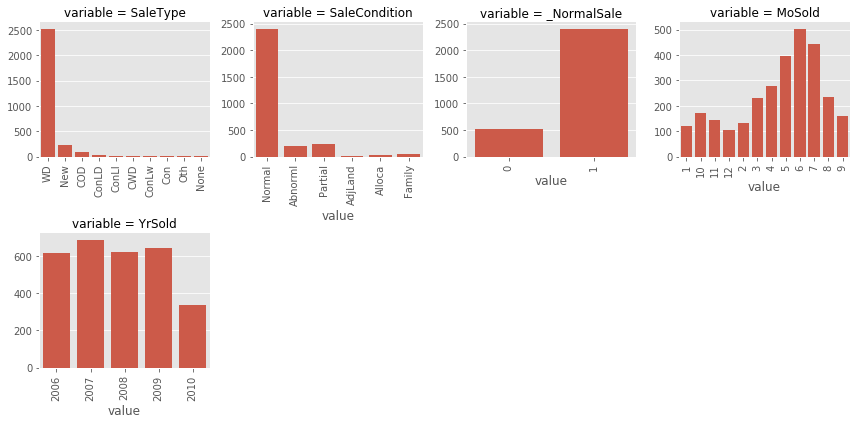

In [76]:
if show_hist:
    plot_counts(cat_sale)

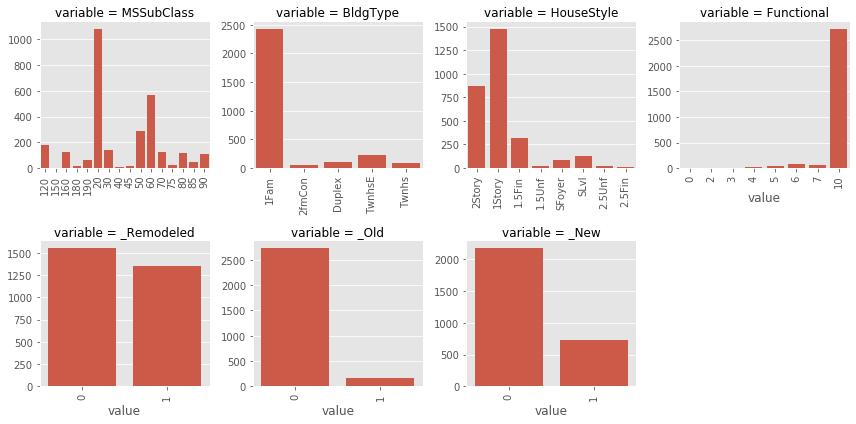

In [77]:
if show_hist:
    plot_counts(cat_type)

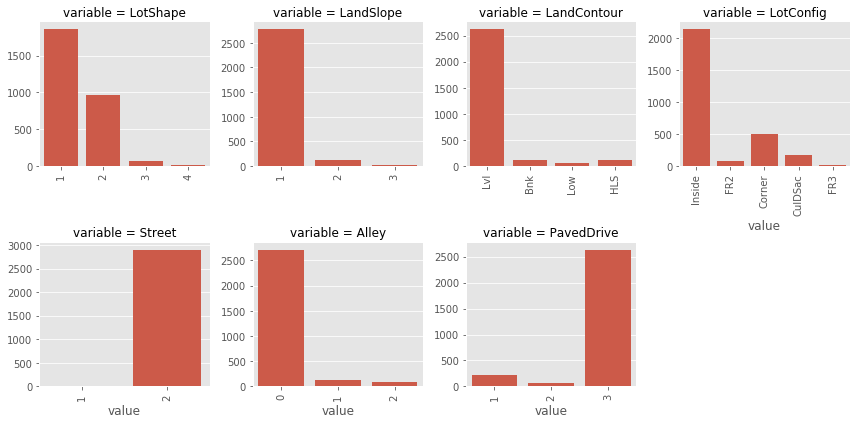

In [78]:
if show_hist:
    plot_counts(cat_land)

## Influential features

In [79]:
#Select least p-value features on the F-test. Visualize Boxplots (Price or LogPrice?)

In [80]:
cat_influential = [
# from cat_location
'Neighborhood',
'MSZoning',
# from the cat_sale
'SaleCondition',
'SaleType',    
# from cat_type
'MSSubClass',
'_Old',
'_New',    
# zero from the cat_land
# from cat_qual
'OverallQual', 
'OverallCond',
'KitchenQual',
'FireplaceQu',
'Foundation',
'HeatingQC',
'CentralAir',    
'MasVnrType',
'_Porch',  
    
'Exterior1st',
'Exterior2nd',
'ExterQual',   
    
'GarageFinish',
'GarageType',
'GarageQual',    
'GarageCond',
'_Garage',    
    
'BsmtQual',
'BsmtExposure',    
'BsmtFinType1',    
]
print(f'Inflential features:  {len(cat_influential)}')


Inflential features:  27


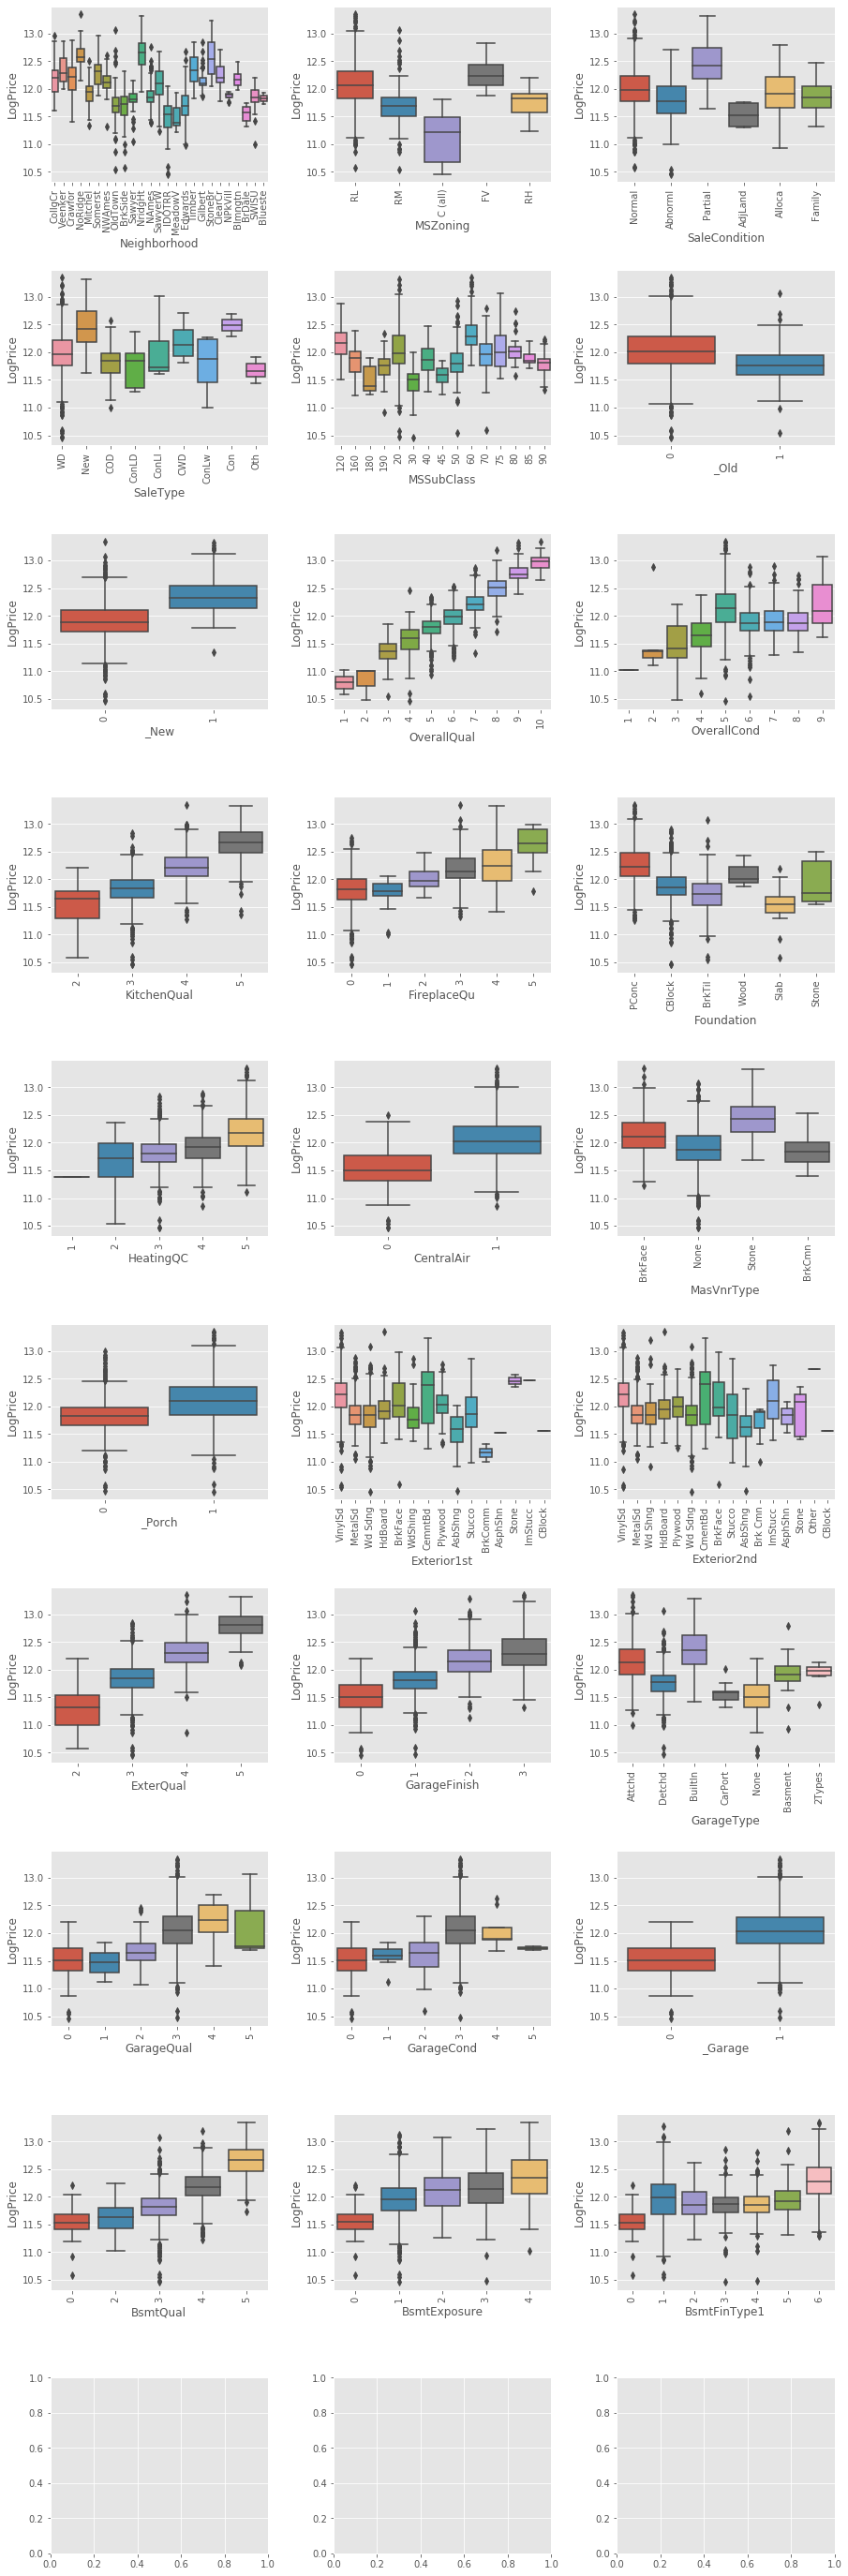

In [81]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

# plt.subplots(nrows, ncols, figsize=(width, height))
nc  = 3
nr  = 1+len(cat_influential)//nc
f,axes = plt.subplots(nr, nc, figsize=(nc*5, nr*5))
f.subplots_adjust(hspace=.5, wspace=.3,)

counter = 0
for f in cat_influential:
    ax = sns.boxplot(f, 'LogPrice', data=train_processed, ax = axes[counter//nc][counter%nc])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    counter+=1


# NUMERICAL

In [82]:
# divide into 3 groups
len(num_features)

31

In [83]:
num_continous = [
'LotFrontage',
'LotArea',
'MasVnrArea',
'BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
'GarageArea',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea',
'MiscVal',
]

num_count = [
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageCars',      
]

num_buckets = [
'YearBuilt',
'YearRemodAdd',
'GarageYrBlt',
]


In [84]:
len(num_continous) + len(num_buckets) + len(num_count)

31

In [85]:
df[num_continous].shape

(2915, 19)

In [86]:
df[num_continous].isnull().sum(axis=0)

LotFrontage      486
LotArea            0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
dtype: int64

## Impute missing values

In [87]:
#Rob:
#impute missing values using KNN -- use all features in training set impute missing values for LotFrontage & MasVnr

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors= round(np.sqrt(train[num_continous].shape[0])))

imputer.fit(train['LotFrontage'][:,np.newaxis])
df['LotFrontage'] = imputer.transform(df['LotFrontage'][:,np.newaxis])

imputer.fit(train['MasVnrArea'][:,np.newaxis])
df['MasVnrArea'] = imputer.transform(df['MasVnrArea'][:,np.newaxis])


In [88]:
# sum(df.isnull().sum(axis=0))
for f in df.columns:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

1   nans in   BsmtFinSF1
1   nans in   BsmtFinSF2
1   nans in   BsmtUnfSF
1   nans in   TotalBsmtSF
2   nans in   BsmtFullBath
2   nans in   BsmtHalfBath
159   nans in   GarageYrBlt
1   nans in   GarageCars
1   nans in   GarageArea


In [89]:
# Explore GarageYrBlt
df[df.GarageYrBlt.isna() & df._Garage==1]

MSSubClass MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
666         60       RM         57.0     8094       2      1         1   

    LandContour  Utilities LotConfig  ...  _Fence _Porch _MasVnrArea  \
666         Lvl          4    Inside  ...       1      1           0   

    _WoodDeck _MiscFeature _New  _Old  _Remodeled  _NormalSale  _AfterWW2  
666         1            1    0     1           1            1          0  

[1 rows x 92 columns]

In [90]:
# replace all with zeros
for f in df.columns:
    df[f].fillna(0, inplace=True)                

In [91]:
#Rob: making the merge easier by creating the df train
train = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

## Numerical features: Correlations & transformations

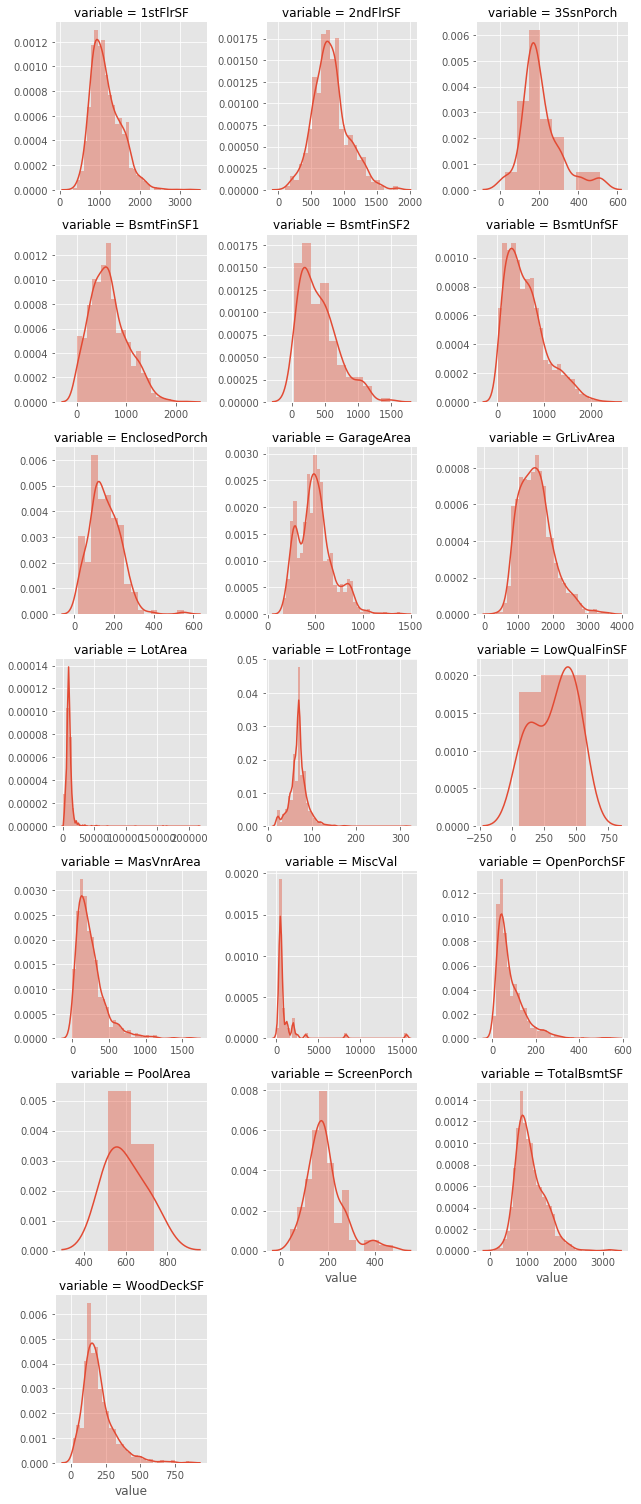

In [92]:
#density plots of original numerica features
f = pd.melt(train[num_continous][train[num_continous]>0], value_vars=sorted(num_continous))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

pretty much every numerical feature exhibits right skewness - these are good candidates for log transformation

In [93]:
##transform all numerical values
train_transformed = train[num_continous].copy()

for f in num_continous:
    train_transformed.loc[:,f] = np.log1p(train[f])

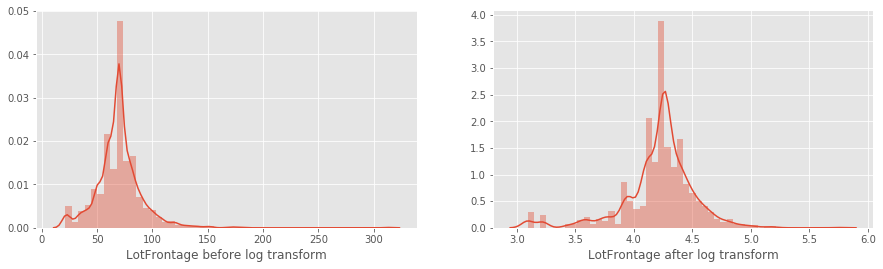

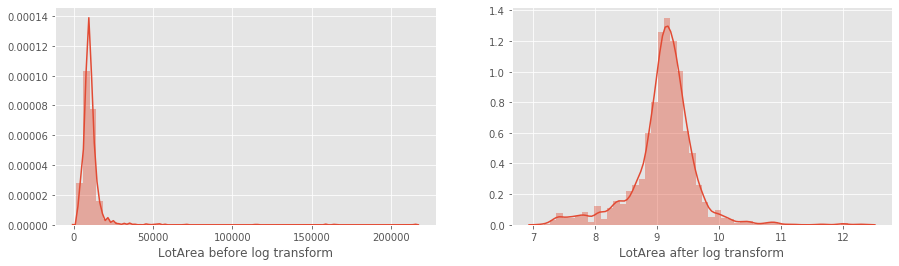

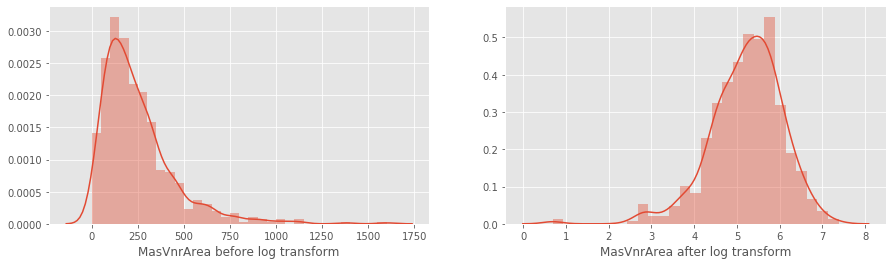

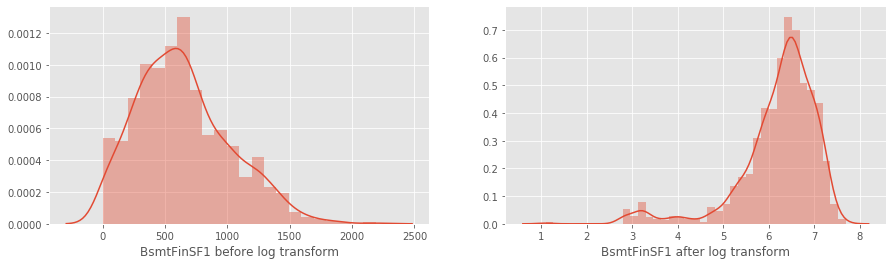

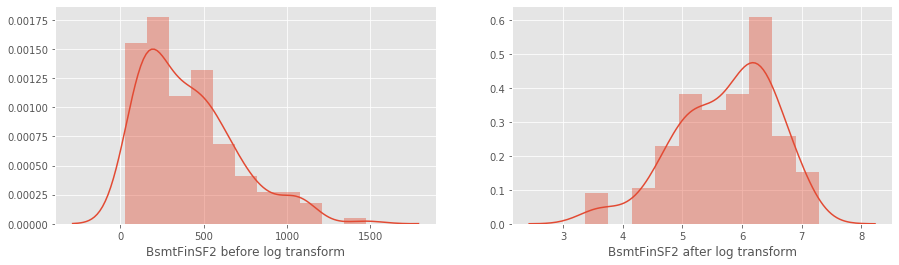

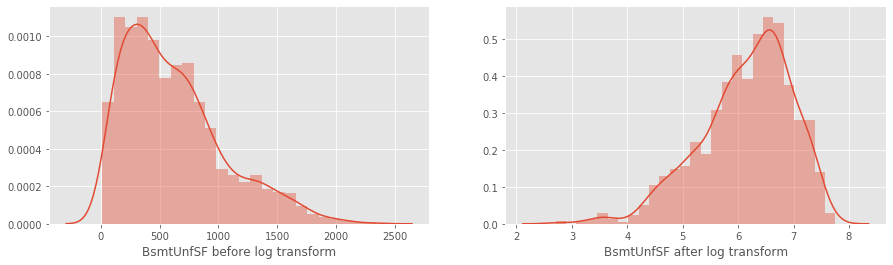

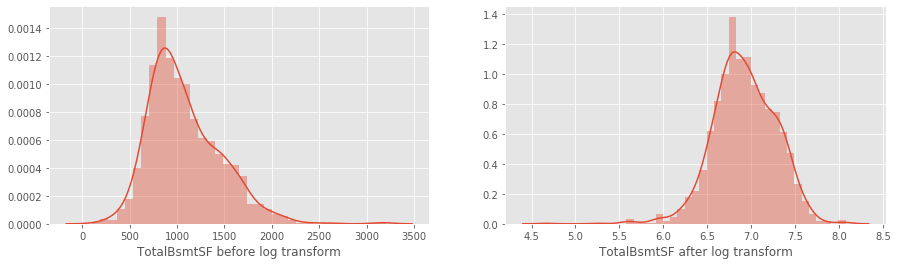

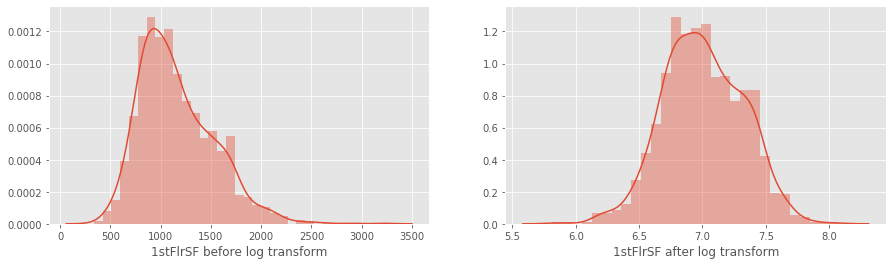

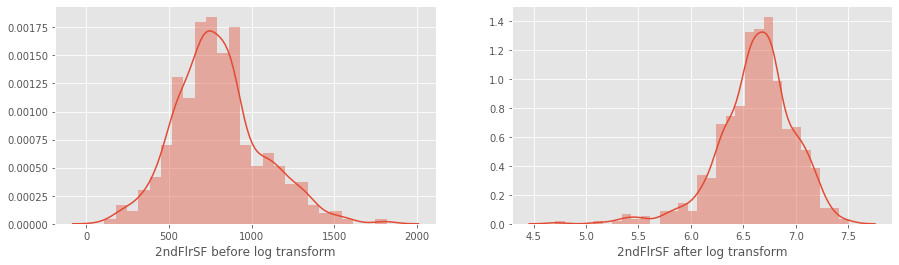

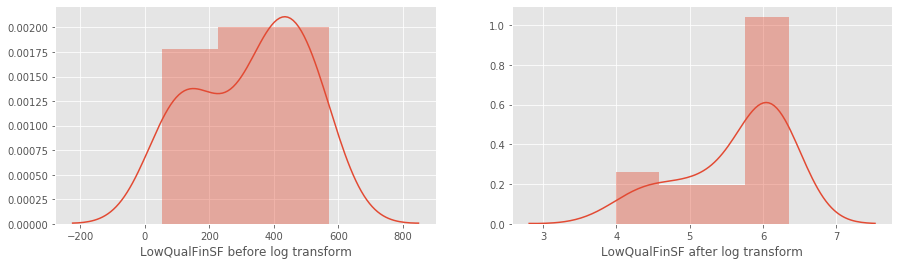

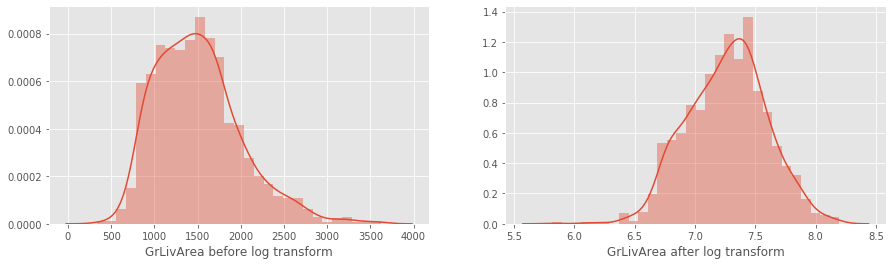

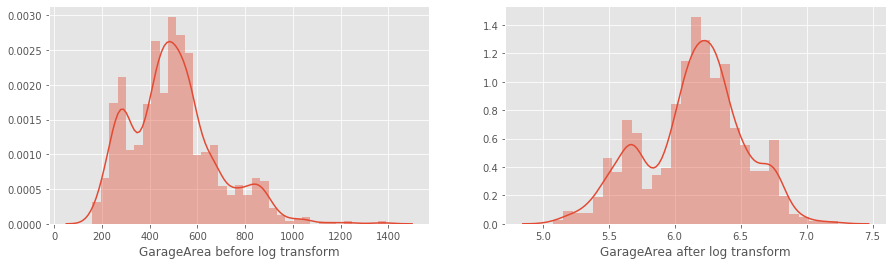

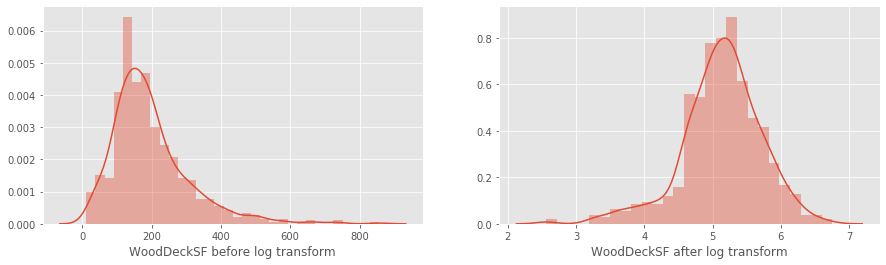

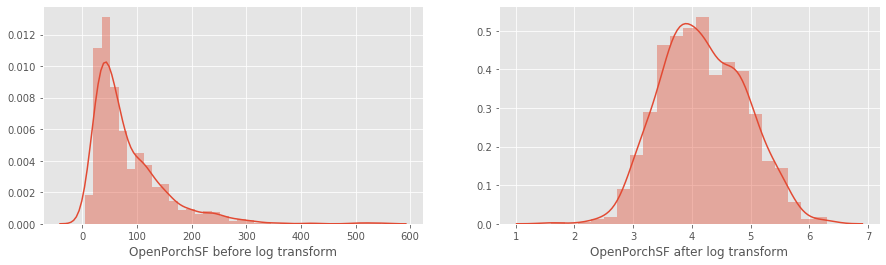

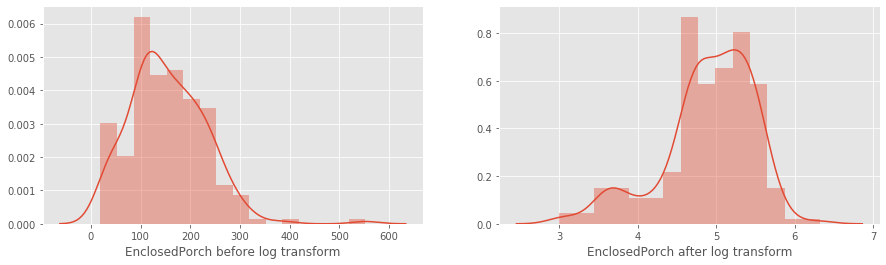

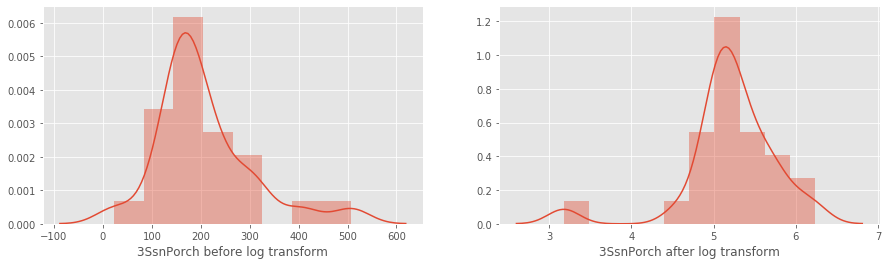

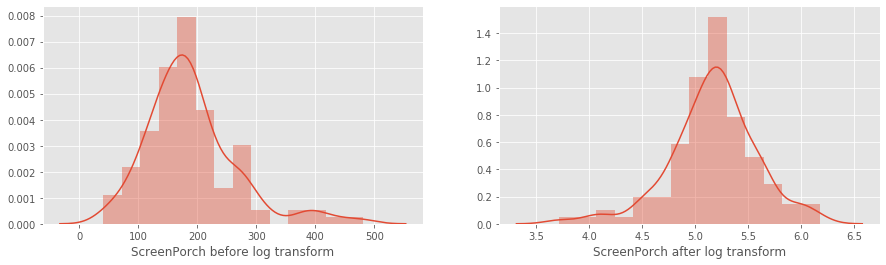

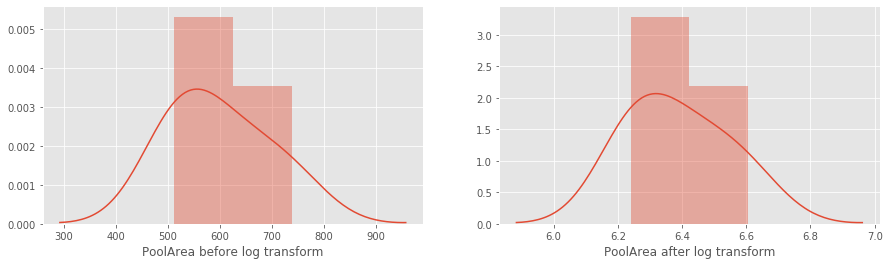

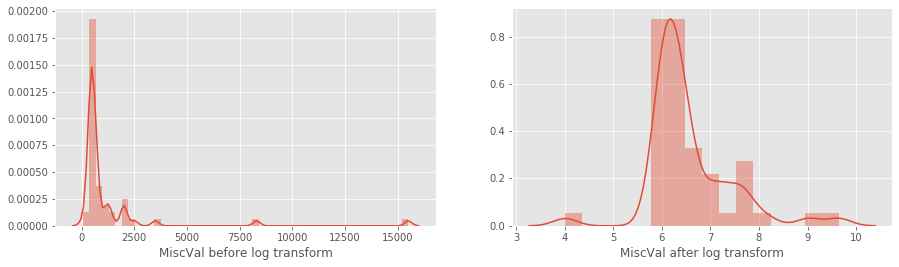

In [94]:
##plot before and after charts
for f in num_continous:
    fig,axes = plt.subplots(1, 2, figsize=(15, 4))
    g = sns.distplot(train[f][train[f] != 0], ax=axes[0])
    g.set(xlabel =f"{f} before log transform")
    g = sns.distplot(train_transformed[f][train_transformed[f] != 0], ax=axes[1])
    g.set(xlabel =f"{f} after log transform")


numerical features are closer to the normal curve post transformation

In [95]:

train_transformed.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

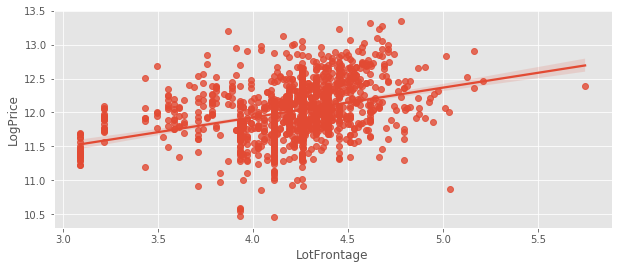

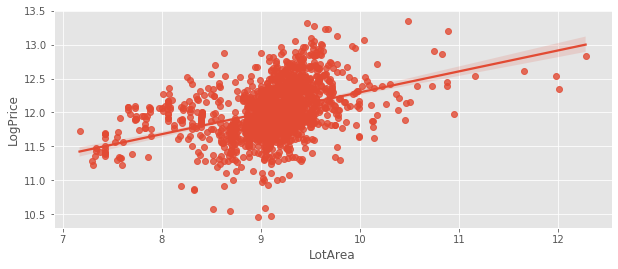

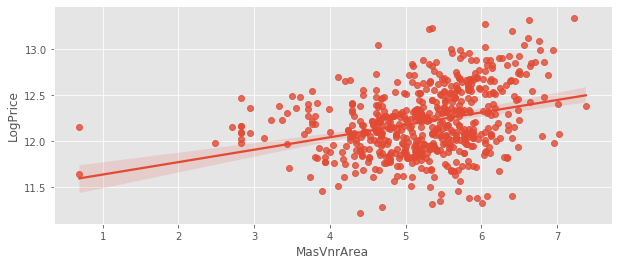

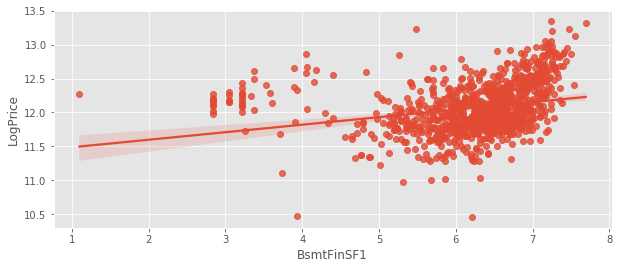

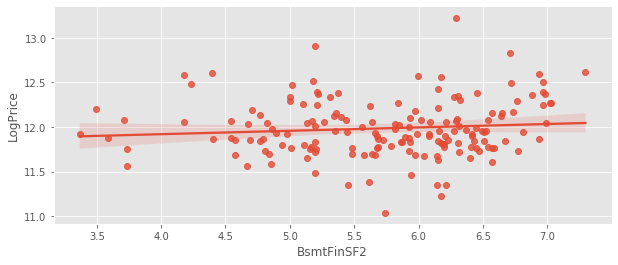

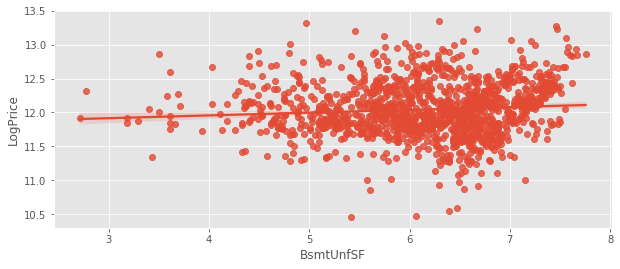

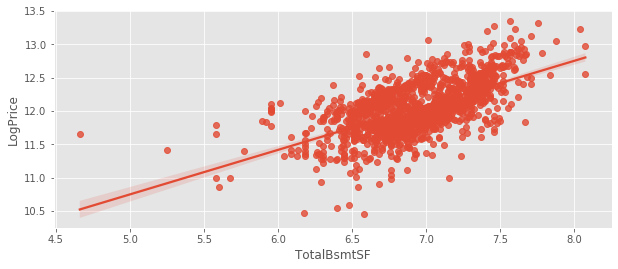

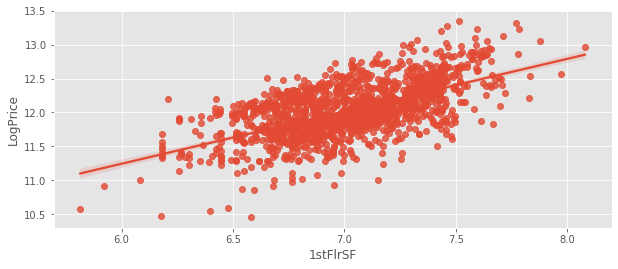

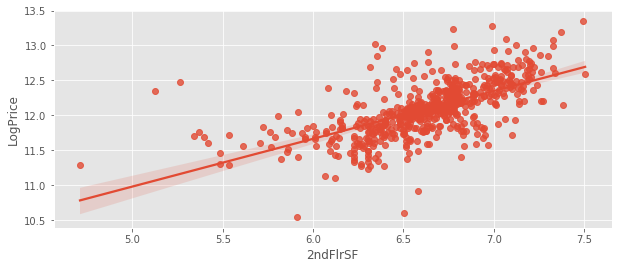

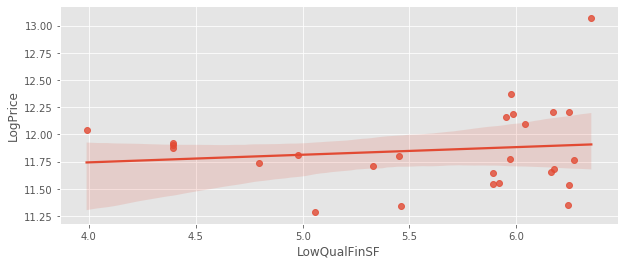

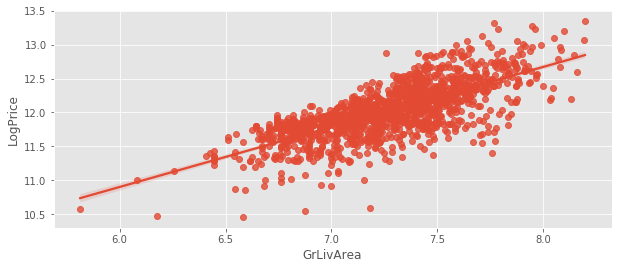

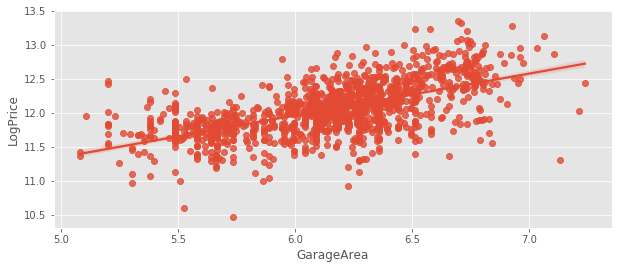

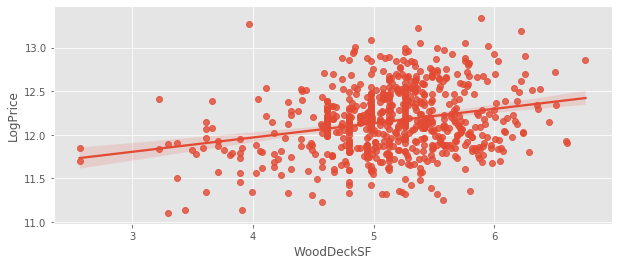

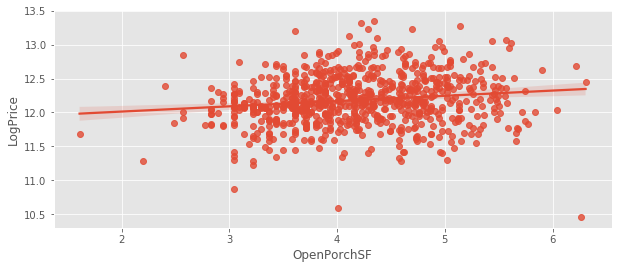

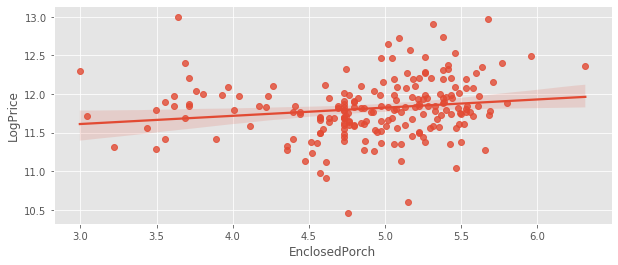

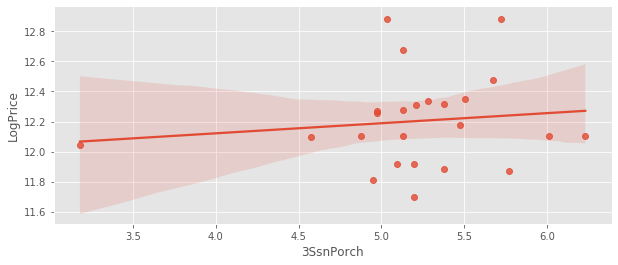

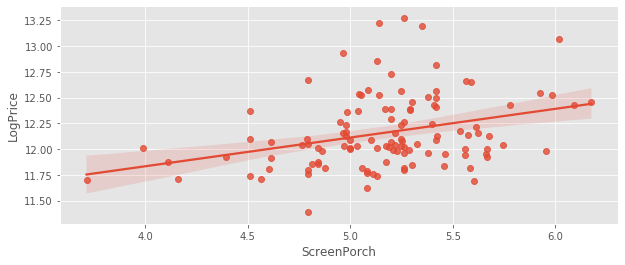

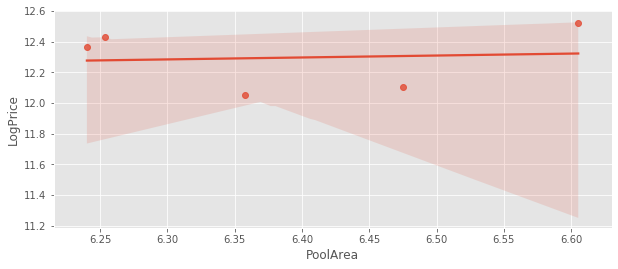

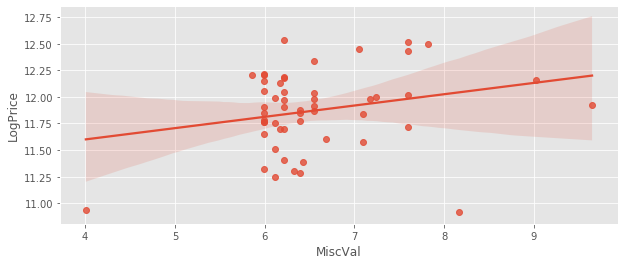

In [96]:
##scatter plot of saleprice vs the log transformed predictors
#num_continous = num_continous.remove('LogPrice')

for f in num_continous:
    fig,axes = plt.subplots(1, 1, figsize=(10, 4))
    g = sns.regplot(train_transformed[f][train_transformed[f]!=0], train['LogPrice'][train_transformed[f]!=0])
    

BsmtFinSF1 might fit better with quadratic.
Strongest linear relationships:
    LotFrontage, LotArea, MasVnrArea,TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, GarageArea, WoodDeckSF

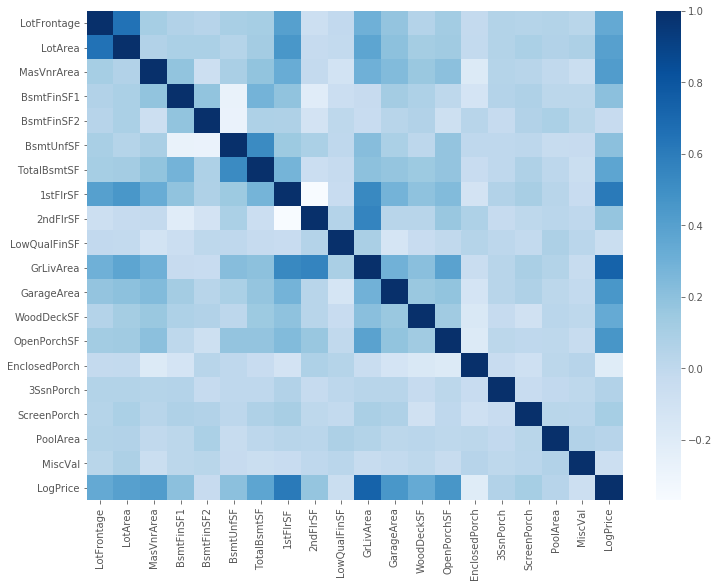

In [97]:
#another way is to look at their correlation to LogPrice
train_transformed['LogPrice'] = train['LogPrice']
corMatrix = train_transformed.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corMatrix, cmap="Blues")

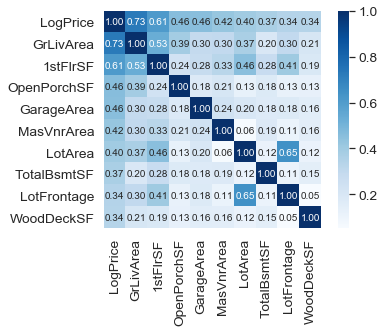

In [98]:
##hone in on top k most correlated
k = 10 #number of variables for heatmap
cols = corMatrix.nlargest(k, 'LogPrice')['LogPrice'].index
cm = np.corrcoef(train_transformed[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="Blues", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

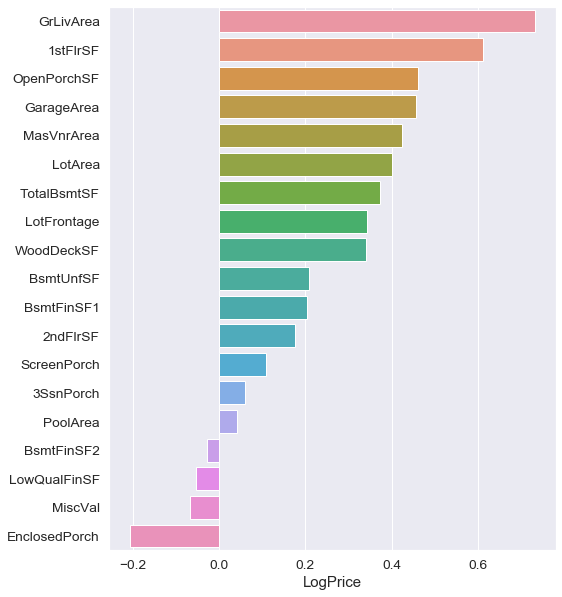

In [99]:
#another view of correlation to saleprice
corr = corMatrix.sort_values('LogPrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.LogPrice[1:], corr.index[1:], orient='h')
plt.show()

In [100]:
list(corMatrix.columns)

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'LogPrice']

In [101]:
if apply_transform:
    for f in num_continous:
        df.loc[:,f] = np.log1p(df[f])

## Standardize

In [102]:
# standardize LogPrice, save the scaler for the inverse transform
if apply_standardization:
    logprice_scaler = StandardScaler().fit(LogPrice[:,np.newaxis])
    Y = logprice_scaler.transform(LogPrice[:,np.newaxis])

In [103]:
# standardize numerical predictors. fit on train, transorm both train and test
if apply_standardization:
    for f in num_continous:
        scaler = StandardScaler().fit(df[f][:len(LogPrice), np.newaxis])
        df[f] = scaler.transform(df[f][:,np.newaxis])

## Feature Generation

In [104]:
##adding some numerical features that are usually looked at together

# df['TotalSF'] = df.TotalBsmtSF + df.GrLivArea
# df['TotalFloorSF'] = df['1stFlrSF'] + df['2ndFlrSF']
# df['TotalPorchSF'] = df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch
# num_continous += ['TotalSF','TotalFloorSF','TotalPorchSF']

# Features Checkpoint

In [105]:
df_dummified = pd.get_dummies(df, drop_first=True)

# X = df_dummified
X_train = df_dummified.iloc[:len(Y), :]
X_test  = df_dummified.iloc[len(Y):, :]

df_dummified.shape, X_train.shape, X_test.shape, Y.shape 

((2915, 245), (1456, 245), (1459, 245), (1456, 1))

In [106]:
import time
df_dummified.to_csv(f'data/features_{round(time.time())}.csv', index=False)


# ============ MODEL ============

## Select cross validation K

In [107]:
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import sklearn.model_selection as ms


In [108]:
lasso = linear_model.Lasso(alpha=0.001) 
lasso.fit(X_train, Y) 

r2 = lasso.score(X_train, Y)
beta0 = lasso.intercept_

betas = pd.Series(lasso.coef_, index=X_train.columns)
betas = betas.sort_values(axis=0, ascending=False)  #Rob: showing all betas not just the positive ones

print(r2)
print(beta0)
print(betas)

0.9339250221692598
[-16.3923095]
GrLivArea               0.3108
Neighborhood_Crawfor    0.2914
SaleType_New            0.2677
MSZoning_FV             0.2250
MSZoning_RL             0.2121
                         ...  
Neighborhood_IDOTRR    -0.0717
MSSubClass_30          -0.0726
KitchenAbvGr           -0.0959
MSSubClass_160         -0.1590
Neighborhood_MeadowV   -0.1615
Length: 245, dtype: float64


In [109]:
lasso = linear_model.Lasso(alpha=0.001) 
scores = ms.cross_val_score(estimator=lasso, X=X_train, y=Y, cv=10)

print('Scores: {}'.format(scores))
print('Score mean: {}'.format(scores.mean()))
print('Score std deviation: {}'.format(scores.std()))

Scores: [0.89010187 0.93843213 0.93318334 0.91052145 0.9078193  0.9181271
 0.90660992 0.93772227 0.92731632 0.91085528]
Score mean: 0.9180688961456662
Score std deviation: 0.01497463983783394


In [110]:
r2_mean = []
r2_se = []
 
kfold = range(5,40,5)    
for i in kfold:
    print(f'Evaluating kfold={i}')
    scores = ms.cross_val_score(estimator=lasso, X=X_train, y=Y, cv=i)
    r2_mean.append(scores.mean())
    r2_se.append(scores.std())

Evaluating kfold=5
Evaluating kfold=10
Evaluating kfold=15
Evaluating kfold=20
Evaluating kfold=25
Evaluating kfold=30
Evaluating kfold=35


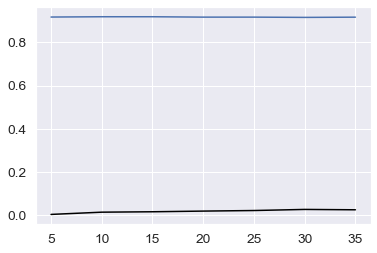

In [111]:
plt.plot(kfold, r2_mean)
plt.plot(kfold, r2_se, color='black')
plt.show()

In [112]:
# CONCLUSION: 
# K=5  is enough, no need for more

## Feature Selection

In [113]:
# VIF check for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["features"] = df_dummified.columns
vif["VIF"] = [variance_inflation_factor(df_dummified.iloc[:len(LogPrice),:].values, i) for i in range(df_dummified.shape[1])]

vif[vif.VIF <5].sort_values(by=['VIF'], ascending=False)

features     VIF
118   Neighborhood_Timber  4.8428
222              MoSold_5  4.7316
99   Neighborhood_ClearCr  4.6351
193       Foundation_Slab  4.6065
113    Neighborhood_SWISU  4.5901
..                    ...     ...
94          LotConfig_FR3  1.2360
50              3SsnPorch  1.2304
232          SaleType_Con  1.1965
126       Condition1_RRNe  1.1914
204       Electrical_None  1.1434

[110 rows x 2 columns]

In [114]:
# mutual information -- a potential filter to select features
# for any 2 rand.vars: KL Divergence between joint PDF and product of marginal PDFs ('information gain')

from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_train, Y)
mi /= np.max(mi)

mi = pd.Series(mi, index=X_train.columns)
mi = mi.sort_values(axis=0, ascending=False)

In [115]:
subset = None

In [116]:
# Option A.  leave only influential
if subset=='influential':

#     df_subset =  df[list(mi[:120].index)]
#     df_dummified = pd.get_dummies(df_subset, drop_first=True)

    df_dummified = df_dummified[list(mi[:200].index)]

    X_train = df_dummified.iloc[:len(Y), :]
    X_test  = df_dummified.iloc[len(Y):, :]


In [117]:
# group features by type, to be fed into the permutations below
feature_groups = {
    'area':    ['GrLivArea','1stFlrSF','2ndFlrSF','LowQualFinSF',],
                'other_continuous': ['LotFrontage','LotArea','MasVnrArea','PoolArea','MiscVal',],
    'counts':  ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                'TotRmsAbvGrd','Fireplaces','GarageCars',],
    'age':     ['YearBuilt','YearRemodAdd','GarageYrBlt',],
    'quality': ['OverallQual','KitchenQual','OverallCond','Exterior1st','Exterior2nd','ExterQual','ExterCond',
                 'MasVnrType', '_MasVnrArea','RoofStyle','RoofMatl',],
    'basement':['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtQual','BsmtCond',
                'BsmtExposure','BsmtFinType1','BsmtFinType2','_Basement',],
    'garage':  ['GarageFinish','GarageQual','GarageCond','GarageType','_Garage',],
    'porch':   ['_Porch','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',],
    'other':   ['GarageArea','WoodDeckSF','Foundation','Electrical','Fence','_Fence','Utilities',
                'Heating','HeatingQC','CentralAir','FireplaceQu','PoolQC','_Pool','_WoodDeck',
                'MiscFeature','_MiscFeature',],
    'location':['MSZoning','Neighborhood','Condition1','Condition2',],
    'sale':    ['SaleType','SaleCondition','_NormalSale','MoSold','YrSold',],
    'house_type': ['MSSubClass','BldgType','HouseStyle','Functional','_Remodeled','_Old','_New','_AfterWW2',],
    'land':    ['LotShape','LandSlope','LandContour','LotConfig','Street','Alley','PavedDrive',],
}

## Grid Search: Helper Functions

In [118]:
def prices_from_normalized(normalized):
    return np.exp(logprice_scaler.inverse_transform(normalized)).round()

In [119]:
def rmsle(y_true, y_hat):
    return np.sqrt(np.mean((np.log(y_true)-np.log(y_hat))**2))

In [120]:
def mae(y_true, y_hat):
    return np.median(np.abs(y_true-y_hat))

In [121]:
def mape(y_true, y_hat):
    return np.median(np.abs(y_true-y_hat)/y_true)

In [122]:
from sklearn.metrics import mean_squared_error, make_scorer
def rmse(y_true, y_pred):
    return mean_squared_error(logprice_scaler.inverse_transform(y_true), 
                              logprice_scaler.inverse_transform(y_pred), 
                              squared=False)

In [123]:
def predict_prices(model, x):
    y_hat = model.predict(x)
    y_hat = logprice_scaler.inverse_transform(y_hat)
    y_hat = np.exp(y_hat).round()
    return y_hat

In [248]:
def visualize_HP(df, HP_xlabel, HP_xvalues):
    f,axes = plt.subplots(1, 2, figsize=(16, 4))
    ax0,ax1=axes[0],axes[1]

    ax0.plot(df.r2_train, label='R2 train full') 
    ax0.plot(df.r2_CV_mean, label='R2 CV mean') 
    ax0.fill_between(range(len(HP_xvalues)), df.r2_CV_mean-2*df.r2_CV_se, df.r2_CV_mean+2*df.r2_CV_se, color='lightgrey')
    ax0.set_xticks(range(len(HP_xvalues)))
    ax0.set_xticklabels(HP_xvalues)
    ax0.set_title('R2:   train vs. cross-validated')
    ax0.set_xlabel(HP_xlabel)
    ax0.legend()

    ax1.plot(df.rmse_train, label='RMSE train full') 
    ax1.plot(df.rmse_CV_mean, label='RMSE CV mean') 
    ax1.fill_between(range(len(HP_xvalues)), df.rmse_CV_mean-2*df.rmse_CV_se, df.rmse_CV_mean+2*df.rmse_CV_se, color='lightgrey')
    ax1.set_xticks(range(len(HP_xvalues)))    
    ax1.set_xticklabels(HP_xvalues)
    ax1.set_title('RMSE (LogPrice):   train vs. cross-validated')
    ax1.set_xlabel(HP_xlabel)
    ax1.legend()

    plt.show()


In [257]:
def visualize_HP_vertical(df, HP_xlabel, HP_xvalues):
    f,axes = plt.subplots(2, 1, figsize=(8, 10))
    ax0,ax1=axes[0],axes[1]

    ax0.plot(df.rmse_train, label='RMSE train full') 
    ax0.plot(df.rmse_CV_mean, label='RMSE CV mean') 
    ax0.fill_between(range(len(HP_xvalues)), df.rmse_CV_mean-2*df.rmse_CV_se, df.rmse_CV_mean+2*df.rmse_CV_se, color='lightgrey')
    ax0.set_xticks(range(len(HP_xvalues)))    
    ax0.set_xticklabels(HP_xvalues)
    ax0.set_title('RMSE (LogPrice):   train vs. cross-validated')
    ax0.set_xlabel('')
    ax0.legend()
    
    
    ax1.plot(df.r2_train, label='R2 train full') 
    ax1.plot(df.r2_CV_mean, label='R2 CV mean') 
    ax1.fill_between(range(len(HP_xvalues)), df.r2_CV_mean-2*df.r2_CV_se, df.r2_CV_mean+2*df.r2_CV_se, color='lightgrey')
    ax1.set_xticks(range(len(HP_xvalues)))
    ax1.set_xticklabels(HP_xvalues)
    ax1.set_title('R2:   train vs. cross-validated')
    ax1.set_xlabel(HP_xlabel)
    ax1.legend()

    plt.show()


In [125]:
def visualize_residuals(SalePrice, train_predictions):
    emp_error = train_predictions - SalePrice

    f,axes = plt.subplots(2, 2, figsize=(12, 12))
    ax0,ax1,ax2,ax3=axes[0,0],axes[0,1],axes[1,0],axes[1,1]

    ax0.scatter(train_predictions,SalePrice, marker='.')
    ax0.plot( (min(SalePrice), max(SalePrice)), (min(SalePrice), max(SalePrice)),color='k')
    ax0.set_title('Train set: actual vs predicted')
    ax0.set_xlabel('predicted price')

    ax1.scatter(train_predictions, emp_error, marker='.')
    ax1.axhline(0, color='k')
    ax1.set_title('Train set: residuals')
    ax1.set_xlabel('predicted price')

    ax2.scatter(train_predictions, emp_error/SalePrice, marker='.')
    ax2.axhline(0, color='k')
    ax2.set_title('% empirical error')
    ax2.set_xlabel('predicted price')

    ax3.hist(emp_error/SalePrice,bins=40)
    ax3.set_title(f'% empirical error. std={np.std(emp_error/SalePrice):.4f}')
    ax3.set_xlabel('% error')

    plt.show()

In [126]:
def visualize_groups(df, HP_xlabel, HP_xvalues, hline):
    f,ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(df.rmse_train, label='RMSE train full', marker='o', linestyle='')
    ax.plot(df.rmse_CV_mean, label='RMSE CV mean', marker='o', linestyle='', color='k') 
    ax.axhline(hline, label='RMSE ALL features', color='c')
    
    ax.fill_between(range(len(HP_xvalues)), df.rmse_CV_mean-2*df.rmse_CV_se, df.rmse_CV_mean+2*df.rmse_CV_se, color='lightgrey')
    
    ax.set_xticks(range(len(HP_xvalues)))
    ax.set_xticklabels(HP_xvalues)
    
    ax.set_title('RMSE (LogPrice):   train vs. cross-validated')
    ax.set_xlabel(HP_xlabel)
    ax.legend()
    
    plt.xticks(rotation=90)
    plt.show()


In [127]:
# the generic structure of a report dataframe
# 2 hyperparameters as inputs, 6 standard outputs, 2 optional outputs (such as # of features selected by LASSO)

df_CV = pd.DataFrame(columns=['Model_name',
                              'HP_1','HP_2', 
                              'r2_train', 'r2_CV_mean', 'r2_CV_se', 
                              'rmse_train', 'rmse_CV_mean', 'rmse_CV_se', 
                              'OUT_1', 'OUT_2'])
df_CV

Empty DataFrame
Columns: [Model_name, HP_1, HP_2, r2_train, r2_CV_mean, r2_CV_se, rmse_train, rmse_CV_mean, rmse_CV_se, OUT_1, OUT_2]
Index: []

In [128]:
def model_scores(model_name, X_train, Y, alpha, rho=0.5):
    
    if model_name == "Lasso":
        model = linear_model.Lasso(alpha=alpha)
    elif model_name == "Ridge":
        model = linear_model.Ridge(alpha=alpha)
    elif model_name == "net":
        model = linear_model.ElasticNet(alpha=alpha, l1_ratio=rho )
    
    model.fit(X_train, Y)

    feat = len(model.coef_[model.coef_ != 0]) 
    
    r2_train = model.score(X_train, Y)
    rmse_train = rmse(model.predict(X_train), Y)
    
    r2_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5)
    rmse_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5, scoring=make_scorer(rmse))

    return (r2_train, r2_scores.mean(), r2_scores.std(), 
           rmse_train, rmse_scores.mean(), rmse_scores.std(), 
           feat)

## LASSO

In [129]:
tic=time.time()
model_name  = "Lasso"   #Rob:adding model name so we can simple compare a table of model performance metrics

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'alpha', 'OUT_1': 'Features'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [0.1, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0]:

    df_report.loc[df_report.shape[0]] = ([model_name] +
                                      [HP_1, None] + 
                                      list(model_scores(model_name, X_train, Y, HP_1)) + 
                                      [None])
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')          

0.1 	0.2 sec
0.01 	0.4 sec
0.003 	0.7 sec
0.001 	1.5 sec
0.0003 	3.2 sec
0.0001 	4.6 sec
0 	6.2 sec


In [130]:
df_report

Model_name   alpha  HP_2  r2_train  r2_CV_mean  r2_CV_se  rmse_train  \
0      Lasso  0.1000  None    0.8517      0.8469    0.0075      0.1525   
1      Lasso  0.0100  None    0.9080      0.9018    0.0079      0.1201   
2      Lasso  0.0030  None    0.9257      0.9136    0.0052      0.1079   
3      Lasso  0.0010  None    0.9339      0.9167    0.0046      0.1018   
4      Lasso  0.0003  None    0.9413      0.9143    0.0055      0.0960   
5      Lasso  0.0001  None    0.9438      0.9073    0.0052      0.0939   
6      Lasso  0.0000  None    0.9449      0.8938    0.0113      0.0929   

   rmse_CV_mean  rmse_CV_se Features OUT_2  
0        0.1545      0.0033       12  None  
1        0.1236      0.0039       35  None  
2        0.1160      0.0045       72  None  
3        0.1140      0.0047      112  None  
4        0.1157      0.0063      162  None  
5        0.1203      0.0067      201  None  
6        0.1288      0.0108      240  None

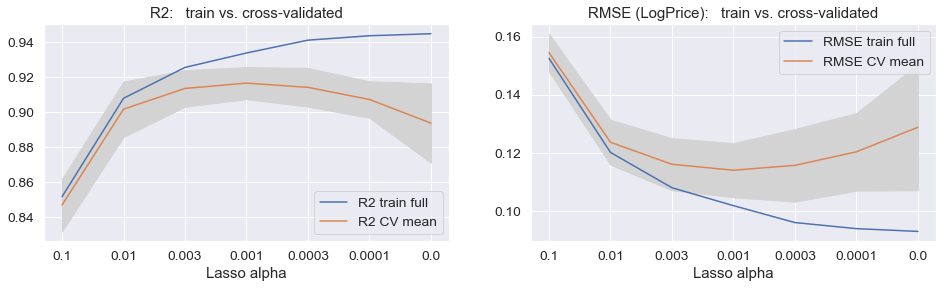

In [131]:
visualize_HP(df_report, 'Lasso alpha', list(df_report.alpha.values))

In [132]:
lasso_best_rmse = min(df_report.rmse_CV_mean)
lasso_best_alpha = df_report[df_report.rmse_CV_mean == lasso_best_rmse].alpha.values[0]
print(f'Best CV rmse: {lasso_best_rmse:.4f}\t  Best alpha: {lasso_best_alpha}')


Best CV rmse: 0.1140	  Best alpha: 0.001


In [133]:
tic=time.time()
df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'dropped_group', 'OUT_1': 'Features'}, inplace=True)

for HP_1 in feature_groups.keys():
    X_reduced = pd.get_dummies(df.drop(feature_groups[HP_1], axis=1), drop_first=True).iloc[:len(Y), :]
    df_report.loc[df_report.shape[0]] = (['Lasso'] +
                                      [HP_1, None] + 
                                      list(model_scores('Lasso', X_reduced, Y, lasso_best_alpha)) + 
                                      [None])
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')

area 	0.5 sec
other_continuous 	1.4 sec
counts 	2.3 sec
age 	3.1 sec
quality 	3.9 sec
basement 	4.6 sec
garage 	5.3 sec
porch 	6.2 sec
other 	6.9 sec
location 	7.7 sec
sale 	8.5 sec
house_type 	9.2 sec
land 	9.9 sec


In [134]:
df_report=df_report.sort_values(by='rmse_CV_mean', ascending=False, ignore_index=True)
df_report

Model_name     dropped_group  HP_2  r2_train  r2_CV_mean  r2_CV_se  \
0       Lasso           quality  None    0.9195      0.8972    0.0114   
1       Lasso          location  None    0.9232      0.9052    0.0052   
2       Lasso              area  None    0.9253      0.9055    0.0056   
3       Lasso          basement  None    0.9283      0.9120    0.0050   
4       Lasso        house_type  None    0.9294      0.9122    0.0044   
5       Lasso             other  None    0.9309      0.9144    0.0052   
6       Lasso               age  None    0.9322      0.9150    0.0044   
7       Lasso              sale  None    0.9310      0.9152    0.0061   
8       Lasso  other_continuous  None    0.9320      0.9153    0.0047   
9       Lasso            counts  None    0.9322      0.9157    0.0051   
10      Lasso             porch  None    0.9326      0.9160    0.0053   
11      Lasso              land  None    0.9329      0.9165    0.0045   
12      Lasso            garage  None    0.9336      0.9168    0.0049   

    rmse_train  rmse_CV_mean  rmse_CV_se Features OUT_2  
0       0.1123        0.1263      0.0047      111  None  
1       0.1097        0.1215      0.0035       93  None  
2       0.1082        0.1215      0.0069      117  None  
3       0.1060        0.1171      0.0036      110  None  
4       0.1052        0.1171      0.0050      103  None  
5       0.1041        0.1155      0.0036      103  None  
6       0.1031        0.1151      0.0044      107  None  
7       0.1040        0.1150      0.0060      107  None  
8       0.1032        0.1149      0.0048      107  None  
9       0.1031        0.1147      0.0048      106  None  
10      0.1028        0.1144      0.0047      105  None  
11      0.1025        0.1141      0.0050      103  None  
12      0.1020        0.1139      0.0049      106  None

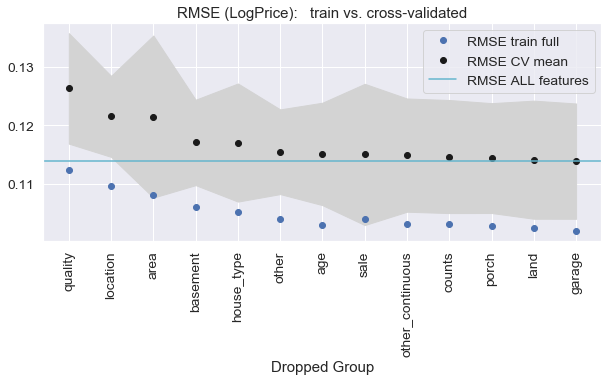

In [135]:
visualize_groups(df_report, 'Dropped Group', df_report.dropped_group, lasso_best_rmse)

In [136]:
df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'dropped_group', 'OUT_1': 'Features'}, inplace=True)
dropped = feature_groups['porch']+feature_groups['garage']+feature_groups['land']

X_train_reduced = pd.get_dummies(df.drop(dropped, axis=1), drop_first=True).iloc[:len(Y), :]
X_test_reduced = pd.get_dummies(df.drop(dropped, axis=1), drop_first=True).iloc[len(Y):, :]

df_report.loc[df_report.shape[0]] = (['Lasso'] +
                                  ['- p,g,l', None] + 
                                  list(model_scores('Lasso', X_train_reduced, Y, lasso_best_alpha)) + 
                                  [None])
df_report

Model_name dropped_group  HP_2  r2_train  r2_CV_mean  r2_CV_se  rmse_train  \
0      Lasso       - p,g,l  None    0.9312      0.9159    0.0056      0.1039   

   rmse_CV_mean  rmse_CV_se Features OUT_2  
0        0.1145      0.0054       97  None

From CV data, the best LASSO appears to exclude porch, garage, land.
However, the final performance on the test set is worse! The same tested and confirmed on Ridge.
#__Conclusion: do not pre-select the features before feeding into the model__


In [137]:
lasso_best = linear_model.Lasso(alpha=lasso_best_alpha)
# lasso_best.fit(X_train_reduced, Y)  #<- performance worse than ful features
lasso_best.fit(X_train, Y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [138]:
coefs = pd.DataFrame({'coefs':lasso_best.coef_,'Positive':lasso_best.coef_ > 0}, index=X_train.columns)
print(f'LASSO dropped {sum(coefs.coefs==0)} of {coefs.shape[0]} features.  Remaining: {sum(coefs.coefs!=0)}')

LASSO dropped 133 of 245 features.  Remaining: 112


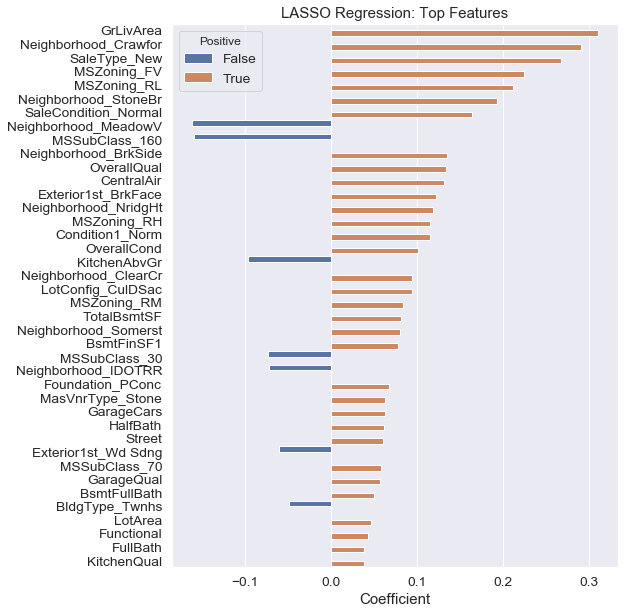

In [139]:
coefs['coefs_abs'] = np.abs(coefs.coefs)
top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(40)

plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Coefficient')
plt.show()

In [140]:
lasso_features = list(coefs[coefs.coefs!=0].index)

In [141]:
# to be ensembled and/or saved as submission
y_hat_lasso = predict_prices(lasso_best, X_test)
train_predictions = predict_prices(lasso_best, X_train)

In [205]:
print(f'Empirical MAE = {mae(SalePrice, train_predictions):,.0f}')
print(f'Empirical MAPE = {100*mape(SalePrice, train_predictions):.2f}%')
print(f'Empirical RMSLE = {rmsle(SalePrice, train_predictions):.4f}')

Empirical MAE = 6,935
Empirical MAPE = 4.30%
Empirical RMSLE = 0.0809


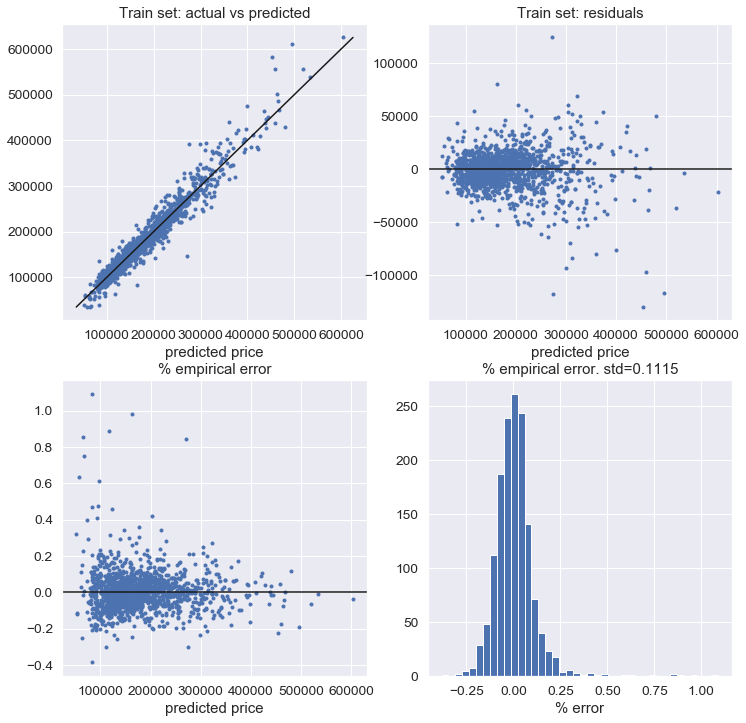

In [143]:
visualize_residuals(SalePrice, train_predictions)

## RIDGE

In [237]:
tic=time.time()
model_name  = "Ridge"   #Rob:adding model name so we can simple compare a table of model performance metrics

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'alpha', 'OUT_1': 'Features'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [1000, 500, 100, 50, 20, 10, 1, 0.1]:
    df_report.loc[df_report.shape[0]] = ([model_name] +
                                      [HP_1, None] + 
                                      list(model_scores(model_name, X_train, Y, HP_1)) + 
                                      [None])
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')      

1000 	0.2 sec
500 	0.3 sec
100 	0.5 sec
50 	0.7 sec
20 	0.8 sec
10 	1.0 sec
1 	1.1 sec
0.1 	1.2 sec


In [238]:
df_report

Model_name alpha  HP_2  r2_train  r2_CV_mean  r2_CV_se  rmse_train  \
0      Ridge  1000  None    0.8974      0.8856    0.0060      0.1268   
1      Ridge   500  None    0.9099      0.8988    0.0048      0.1189   
2      Ridge   100  None    0.9261      0.9120    0.0040      0.1076   
3      Ridge    50  None    0.9304      0.9141    0.0041      0.1044   
4      Ridge    20  None    0.9347      0.9151    0.0042      0.1012   
5      Ridge    10  None    0.9372      0.9148    0.0044      0.0992   
6      Ridge     1  None    0.9431      0.9094    0.0053      0.0945   
7      Ridge   0.1  None    0.9448      0.9006    0.0070      0.0931   

   rmse_CV_mean  rmse_CV_se Features OUT_2  
0        0.1335      0.0030      240  None  
1        0.1256      0.0027      240  None  
2        0.1171      0.0037      240  None  
3        0.1157      0.0040      240  None  
4        0.1151      0.0044      240  None  
5        0.1153      0.0047      240  None  
6        0.1189      0.0063      240  None  
7        0.1246      0.0084      240  None

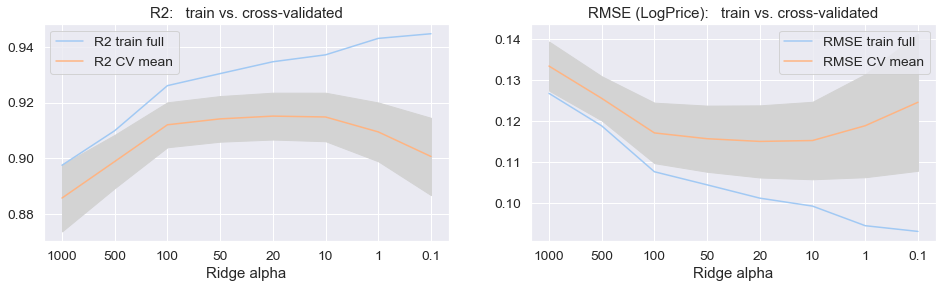

In [249]:
visualize_HP(df_report, 'Ridge alpha', list(df_report.alpha.values))

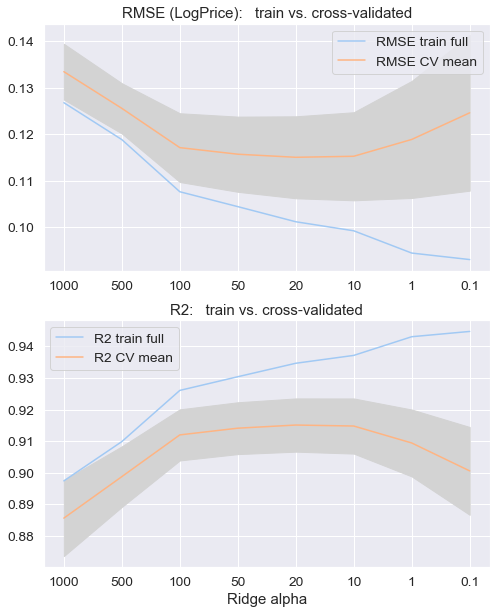

In [258]:
visualize_HP_vertical(df_report, 'Ridge alpha', list(df_report.alpha.values))

In [147]:
ridge_best_rmse = min(df_report.rmse_CV_mean)
ridge_best_alpha = df_report[df_report.rmse_CV_mean == ridge_best_rmse].alpha.values[0]
print(f'Best CV rmse: {ridge_best_rmse:.4f}\t  Best alpha: {ridge_best_alpha}')


Best CV rmse: 0.1151	  Best alpha: 20


In [148]:
ridge_best = linear_model.Ridge(alpha=ridge_best_alpha)
ridge_best.fit(X_train, Y)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

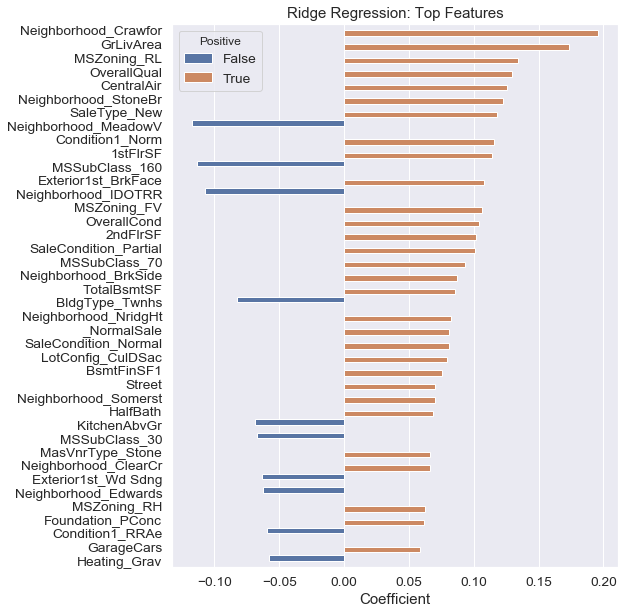

In [149]:
coefs = pd.DataFrame({'coefs':ridge_best.coef_.flatten(),
                      'Positive':ridge_best.coef_.flatten() > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(40)

plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('Ridge Regression: Top Features')
plt.xlabel('Coefficient')
plt.show()


In [150]:
# to be ensembled and/or saved as submission
y_hat_ridge = predict_prices(ridge_best, X_test)
train_predictions = predict_prices(ridge_best, X_train)

y_hat_ridge, train_predictions = np.squeeze(y_hat_ridge), np.squeeze(train_predictions)

In [204]:
print(f'Empirical MAE = {mae(SalePrice, train_predictions):,.0f}')
print(f'Empirical MAPE = {100*mape(SalePrice, train_predictions):.2f}%')
print(f'Empirical RMSLE = {rmsle(SalePrice, train_predictions):.4f}')

Empirical MAE = 6,935
Empirical MAPE = 4.30%
Empirical RMSLE = 0.0809


In [152]:
#visualize_residuals(SalePrice, train_predictions)

## Elastic Net

In [153]:
tic=time.time()
model_name  = "net"   #Rob:adding model name so we can simple compare a table of model performance metrics

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'alpha', 'HP_2': 'rho', 'OUT_1': 'Features'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [0.1, 0.01, 0.001, 0.0005]:
    for HP_2 in [0.1, 0.5, 1]:
        df_report.loc[df_report.shape[0]] = ([model_name] +
                                          [HP_1, HP_2] + 
                                          list(model_scores(model_name, X_train, Y, HP_1, HP_2)) + 
                                          [None])
        print(f'{HP_1} \t{HP_2} \t{time.time()-tic:.1f} sec')      


0.1 	0.1 	0.2 sec
0.1 	0.5 	0.3 sec
0.1 	1 	0.5 sec
0.01 	0.1 	1.0 sec
0.01 	0.5 	1.3 sec
0.01 	1 	1.5 sec
0.001 	0.1 	3.2 sec
0.001 	0.5 	4.6 sec
0.001 	1 	5.5 sec
0.0005 	0.1 	7.2 sec
0.0005 	0.5 	8.8 sec
0.0005 	1 	10.1 sec


In [154]:
df_report

Model_name   alpha  rho  r2_train  r2_CV_mean  r2_CV_se  rmse_train  \
0         net  0.1000  0.1    0.9051      0.8992    0.0067      0.1220   
1         net  0.1000  0.5    0.8827      0.8778    0.0088      0.1356   
2         net  0.1000  1.0    0.8517      0.8469    0.0075      0.1525   
3         net  0.0100  0.1    0.9312      0.9162    0.0044      0.1039   
4         net  0.0100  0.5    0.9181      0.9087    0.0057      0.1133   
5         net  0.0100  1.0    0.9080      0.9018    0.0079      0.1201   
6         net  0.0010  0.1    0.9415      0.9122    0.0050      0.0958   
7         net  0.0010  0.5    0.9379      0.9162    0.0051      0.0987   
8         net  0.0010  1.0    0.9339      0.9167    0.0046      0.1018   
9         net  0.0005  0.1    0.9431      0.9092    0.0052      0.0944   
10        net  0.0005  0.5    0.9412      0.9141    0.0054      0.0960   
11        net  0.0005  1.0    0.9390      0.9165    0.0053      0.0978   

    rmse_CV_mean  rmse_CV_se Features OUT_2  
0         0.1253      0.0026       42  None  
1         0.1379      0.0020       17  None  
2         0.1545      0.0033       12  None  
3         0.1143      0.0044      119  None  
4         0.1193      0.0043       58  None  
5         0.1236      0.0039       35  None  
6         0.1171      0.0060      195  None  
7         0.1143      0.0053      144  None  
8         0.1140      0.0047      112  None  
9         0.1191      0.0065      216  None  
10        0.1158      0.0062      167  None  
11        0.1141      0.0053      141  None

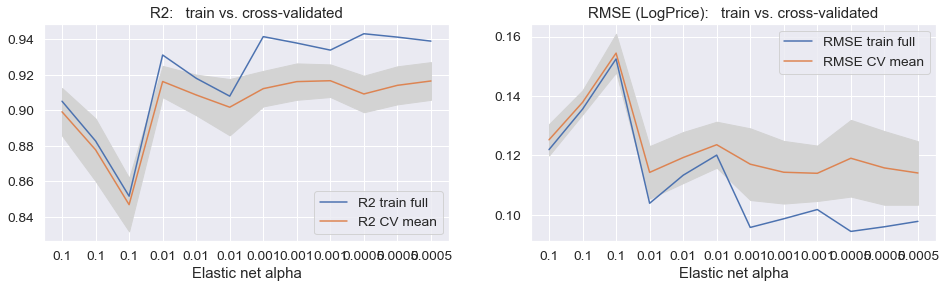

In [155]:
visualize_HP(df_report, 'Elastic net alpha', list(df_report.alpha.values))

In [156]:
# Conclusion: The best performance is when Elastic net rho=1, i.e. pure LASSO

## XGBoost

In [259]:
from xgboost import XGBRegressor

In [260]:
def scores_xgboost(X_train, Y, n_estimators=3000, learning_rate=0.01):

    model = XGBRegressor(learning_rate=learning_rate,   # >>> 0.01
                       n_estimators=n_estimators,   # >>> 3000
                       max_depth=3,          # >>> 3
                       min_child_weight=3,   # another regularization, default 1 >>> 3
                       reg_alpha=0.05,        # L1 reg on weights   >>> 0.05
                       reg_lambda=2,         # >>> 2
                       gamma=0,       # min.similarity threshold 
                       subsample=0.5,         # cross-validation capability   >>> 0.5 not important
                       colsample_bytree=0.25,  # % of features used by tree  >>> 0.25
                       objective= 'reg:squarederror',
                       nthread=-1,            # may help on GPU
                       seed=2020,
                       verbosity=0
                       )
    
    model.fit(X_train, Y)
    
    r2_train = model.score(X_train, Y)
    rmse_train = rmse(model.predict(X_train), Y)
    
    r2_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5)
    rmse_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5, scoring=make_scorer(rmse))

    return (r2_train, r2_scores.mean(), r2_scores.std(), 
           rmse_train, rmse_scores.mean(), rmse_scores.std())

In [266]:
tic=time.time()
model_name  = "XGBoost"  

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'n_estimators', 'HP_2': 'learning_rate'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [3000]:
    for HP_2 in [0.001, 0.004, 0.006, 0.008, 0.01]:
        df_report.loc[df_report.shape[0]] = ([model_name] +
                                             [HP_1, HP_2] +
                                            list(scores_xgboost(X_train, Y, HP_1, HP_2)) + 
                                             [None, None])
        print(f'{HP_1} \t{HP_2} \t{time.time()-tic:.1f} sec')
     

3000 	0.001 	60.7 sec
3000 	0.004 	117.0 sec
3000 	0.006 	176.7 sec
3000 	0.008 	236.2 sec
3000 	0.01 	296.2 sec


In [267]:
df_report

Model_name n_estimators  learning_rate  r2_train  r2_CV_mean  r2_CV_se  \
0    XGBoost         3000          0.001    0.8876      0.8618    0.0104   
1    XGBoost         3000          0.004    0.9530      0.9154    0.0061   
2    XGBoost         3000          0.006    0.9627      0.9177    0.0060   
3    XGBoost         3000          0.008    0.9689      0.9184    0.0054   
4    XGBoost         3000          0.010    0.9736      0.9183    0.0053   

   rmse_train  rmse_CV_mean  rmse_CV_se OUT_1 OUT_2  
0      0.1327        0.1469      0.0088  None  None  
1      0.0858        0.1149      0.0069  None  None  
2      0.0765        0.1133      0.0068  None  None  
3      0.0698        0.1129      0.0066  None  None  
4      0.0643        0.1130      0.0067  None  None

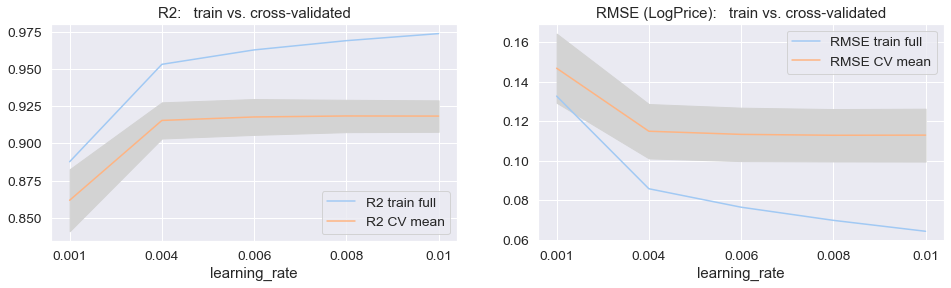

In [268]:
visualize_HP(df_report, 'learning_rate', list(df_report.learning_rate.values))

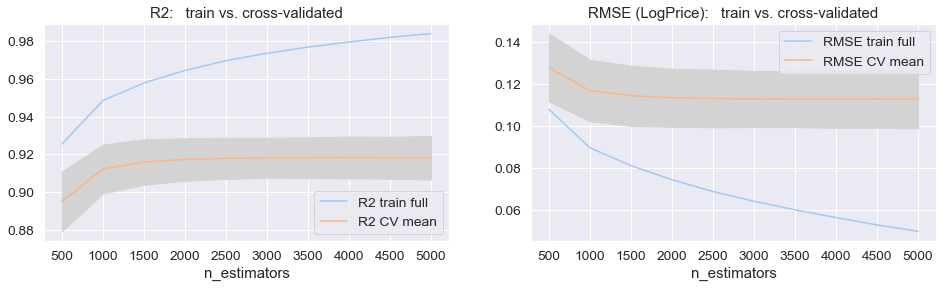

In [265]:
visualize_HP(df_report, 'n_estimators', list(df_report.n_estimators.values))

In [162]:
XGBoost_best =  XGBRegressor(learning_rate=0.01, n_estimators=3000,
                max_depth=3, min_child_weight=3, reg_alpha=0.05, reg_lambda=2, gamma=0,  subsample=0.5,
                colsample_bytree=0.25, objective= 'reg:squarederror', nthread=-1, seed=2020, verbosity=0)
XGBoost_best.fit(X_train, Y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.25, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=2020, reg_alpha=0.05,
             reg_lambda=2, scale_pos_weight=1, seed=2020, subsample=0.5,
             tree_method=None, validate_parameters=False, verbosity=0)

In [163]:
# TRY the subset of features reduced by the best LASSO

In [164]:
tic=time.time()
model_name  = "XGBoost"  

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'n_estimators', 'HP_2': 'learning_rate'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [3000]:
    for HP_2 in [0.012, 0.015, 0.018]:
        df_report.loc[df_report.shape[0]] = ([model_name] +
                                             [HP_1, HP_2] +
                                            list(scores_xgboost(X_train[lasso_features], Y, HP_1, HP_2)) + 
                                             [None, None])
        print(f'{HP_1} \t{HP_2} \t{time.time()-tic:.1f} sec')


3000 	0.012 	35.1 sec
3000 	0.015 	71.3 sec
3000 	0.018 	107.0 sec


In [165]:
df_report

Model_name n_estimators  learning_rate  r2_train  r2_CV_mean  r2_CV_se  \
0    XGBoost         3000          0.012    0.9762      0.9186    0.0058   
1    XGBoost         3000          0.015    0.9807      0.9183    0.0061   
2    XGBoost         3000          0.018    0.9838      0.9173    0.0060   

   rmse_train  rmse_CV_mean  rmse_CV_se OUT_1 OUT_2  
0      0.0610        0.1127      0.0066  None  None  
1      0.0549        0.1130      0.0069  None  None  
2      0.0503        0.1136      0.0072  None  None

In [166]:
XGBoost_best =  XGBRegressor(learning_rate=0.01, n_estimators=3000,
                max_depth=3, min_child_weight=3, reg_alpha=0.05, reg_lambda=2, gamma=0,  subsample=0.5,
                colsample_bytree=0.25, objective= 'reg:squarederror', nthread=-1, seed=2020, verbosity=0)

XGBoost_best.fit(X_train[lasso_features], Y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.25, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=2020, reg_alpha=0.05,
             reg_lambda=2, scale_pos_weight=1, seed=2020, subsample=0.5,
             tree_method=None, validate_parameters=False, verbosity=0)

In [167]:
# to be ensembled and/or saved as submission
y_hat_XGBoost = predict_prices(XGBoost_best, X_test[lasso_features])
train_predictions = predict_prices(XGBoost_best, X_train[lasso_features])

In [203]:
print(f'Empirical MAE = {mae(SalePrice, train_predictions):,.0f}')
print(f'Empirical MAPE = {100*mape(SalePrice, train_predictions):.2f}%')
print(f'Empirical RMSLE = {rmsle(SalePrice, train_predictions):.4f}')

Empirical MAE = 6,935
Empirical MAPE = 4.30%
Empirical RMSLE = 0.0809


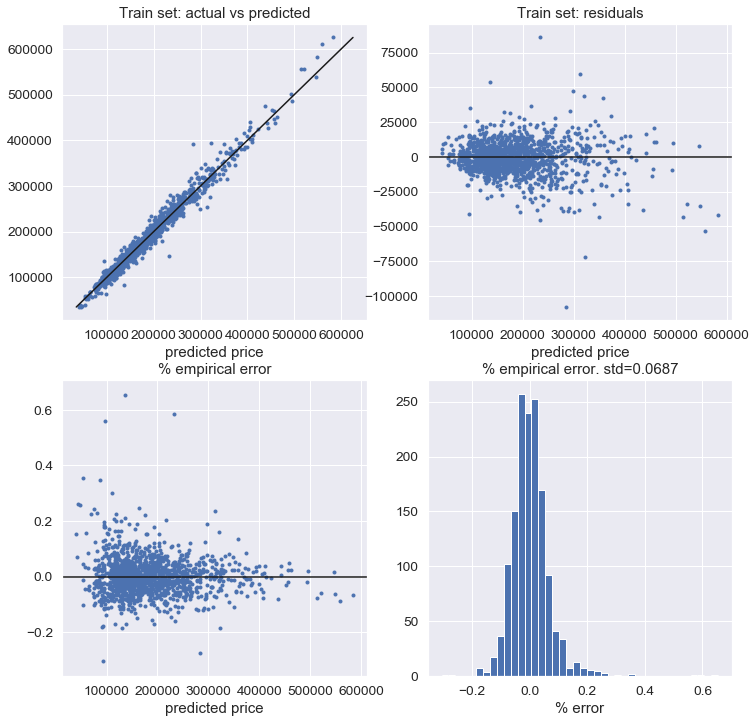

In [169]:
visualize_residuals(SalePrice, train_predictions)

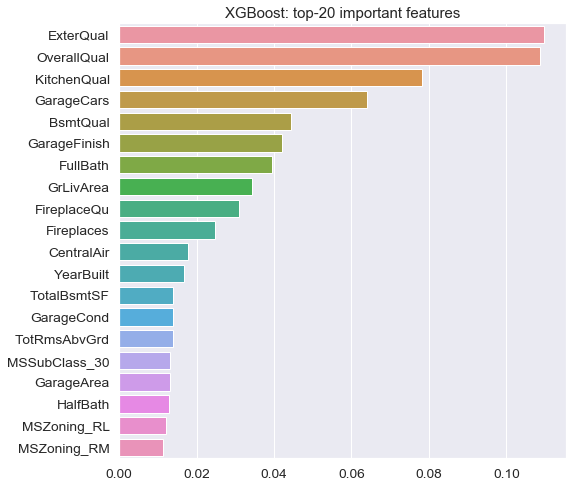

In [170]:
# XGBoost feature importance
fi = pd.Series(XGBoost_best.feature_importances_, index=lasso_features) #X_train.columns)
fi.sort_values(ascending=False, inplace=True)

top_features = 20

plt.figure(figsize=(8,8))
sns.barplot( fi.values[:top_features], fi.index[:top_features], orient='h')
plt.title('XGBoost: top-20 important features')
plt.show()

# Ensembles and Submissions

In [171]:
def save_submission(y_hat, filename_prefix):
    submission_df = pd.DataFrame(data={'Id':test.Id, 'SalePrice':y_hat})
    submission_df.to_csv(f'./submissions/{filename_prefix}_{round(time.time())}.csv', index=False)


In [202]:
# Ridge + XGBoost empirical error
train_predictions_xgboost = predict_prices(XGBoost_best, X_train[lasso_features])
train_predictions_ridge = np.squeeze(predict_prices(ridge_best, X_train))

train_predictions = (train_predictions_xgboost+train_predictions_ridge)/2
print(f'Empirical MAE = {mae(SalePrice, train_predictions):,.0f}')
print(f'Empirical MAPE = {100*mape(SalePrice, train_predictions):.2f}%')
print(f'Empirical RMSLE = {rmsle(SalePrice, train_predictions):.4f}')


Empirical MAE = 6,935
Empirical MAPE = 4.30%
Empirical RMSLE = 0.0809


In [173]:
save = True

if save:
    save_submission(y_hat_lasso, 'FINAL_lasso')
    # 0.12091

    save_submission(y_hat_ridge, 'FINAL_ridge')
    # 0.12048

    save_submission(y_hat_XGBoost, 'FINAL_xgboost')
    # 0.12021

    save_submission( (y_hat_lasso+y_hat_ridge)/2, 'FINAL_lasso_ridge')
    # 0.12049

    save_submission( (y_hat_lasso+y_hat_XGBoost)/2, 'FINAL_lasso_xgboost')
    # 0.11750

    save_submission( (y_hat_XGBoost+y_hat_ridge)/2, 'FINAL_ridge_xgboost')
    # 0.11720

    save_submission( (y_hat_lasso+y_hat_ridge+y_hat_XGBoost)/3, 'FINAL_all3')
    # 0.11769

In [174]:
# save_submission(y_hat_lasso, 'lasso_reduced')

In [175]:
#  save_submission( (y_hat_XGBoost+y_hat_ridge)/2, 'lean_ridge_xgboost')

## Visualized Metrics

In [176]:
# LASSO
Empirical MAE = 8,672
Empirical MAPE = 5.4%
Empirical RMSLE = 0.1018
Test = 0.12091

# Ridge
Empirical MAE = 8,598
Empirical MAPE = 5.2%
Empirical RMSLE = 0.1012
Test = 0.12053

# XGBoost
Empirical MAE = 5,737
Empirical MAPE = 3.5%
Empirical RMSLE = 0.0659
Test = 0.12109

# Ridge + XGBoost
Empirical MAE = 6,935
Empirical MAPE = 4.3%
Empirical RMSLE = 0.0809
Test = 0.11691

SyntaxError: invalid syntax (<ipython-input-176-b77b79cf2c96>, line 2)

In [228]:
sns.set_palette("pastel")


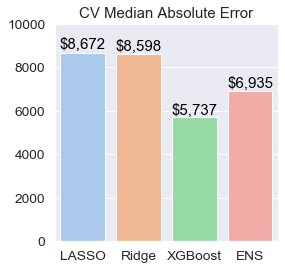

In [229]:
mx = {'LASSO':8_672,'Ridge':8_598,'XGBoost':5_737,'ENS':6_935}

plt.figure(figsize=(4,4))
g=sns.barplot(data=pd.DataFrame(data=mx, index=[1]))
for e, i in enumerate(mx.keys()):
    g.text(e, 1.02*mx[i], f'${mx[i]:,}', color='black', ha="center")

plt.title('CV Median Absolute Error')
plt.ylim(0,10_000)
plt.show()

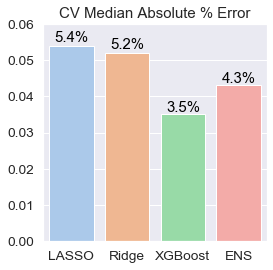

In [230]:
mx = {'LASSO':0.054,'Ridge':0.052,'XGBoost':0.035,'ENS':0.043}

plt.figure(figsize=(4,4))
g=sns.barplot(data=pd.DataFrame(data=mx, index=[1]))
for e, i in enumerate(mx.keys()):
    g.text(e, 1.02*mx[i], f'{100*mx[i]:.1f}%', color='black', ha="center")

plt.title('CV Median Absolute % Error')
plt.ylim(0,0.06)
plt.show()

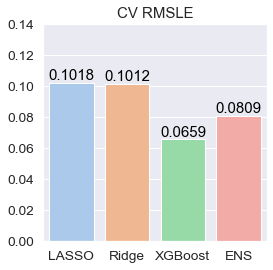

In [231]:
mx = {'LASSO':0.1018,'Ridge':0.1012,'XGBoost':0.0659,'ENS':0.0809}

plt.figure(figsize=(4,4))
g=sns.barplot(data=pd.DataFrame(data=mx, index=[1]))
for e, i in enumerate(mx.keys()):
    g.text(e, 1.02*mx[i], f'{mx[i]:.4f}', color='black', ha="center")

plt.title('CV RMSLE')
plt.ylim(0,0.14)
plt.show()

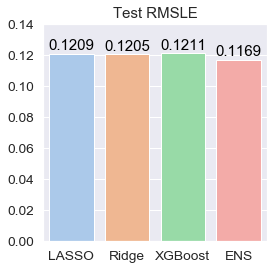

In [234]:
mx = {'LASSO':0.12091,'Ridge':0.12053,'XGBoost':0.12109,'ENS':0.11691}

plt.figure(figsize=(4,4))
g=sns.barplot(data=pd.DataFrame(data=mx, index=[1]))
for e, i in enumerate(mx.keys()):
    g.text(e, 1.02*mx[i], f'{mx[i]:.4f}', color='black', ha="center")

plt.title('Test RMSLE')
plt.ylim(0,0.14)
plt.show()

In [275]:
r = np.where(y_hat_ridge<600_000, y_hat_ridge, 600_000)
x = np.where(y_hat_XGBoost<600_000, y_hat_XGBoost, 600_000)

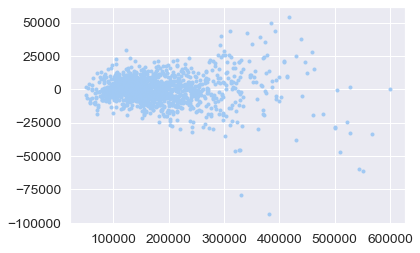

In [276]:
plt.scatter(r, x-r, marker='.')
# ax0.plot( (min(SalePrice), max(SalePrice)), (min(SalePrice), max(SalePrice)),color='k')
# ax0.set_title('Train set: actual vs predicted')
# ax0.set_xlabel('predicted price')


(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   3.,   1.,   0.,   2.,   3.,  10.,  10.,  10.,  33.,  50.,
         83., 170., 226., 268., 267., 156.,  75.,  34.,  19.,  16.,   6.,
          2.,   3.,   2.,   2.,   2.,   1.,   1.]),
 array([-93798.   , -90095.075, -86392.15 , -82689.225, -78986.3  ,
        -75283.375, -71580.45 , -67877.525, -64174.6  , -60471.675,
        -56768.75 , -53065.825, -49362.9  , -45659.975, -41957.05 ,
        -38254.125, -34551.2  , -30848.275, -27145.35 , -23442.425,
        -19739.5  , -16036.575, -12333.65 ,  -8630.725,  -4927.8  ,
         -1224.875,   2478.05 ,   6180.975,   9883.9  ,  13586.825,
         17289.75 ,  20992.675,  24695.6  ,  28398.525,  32101.45 ,
         35804.375,  39507.3  ,  43210.225,  46913.15 ,  50616.075,
         54319.   ]),
 <a list of 40 Patch objects>)

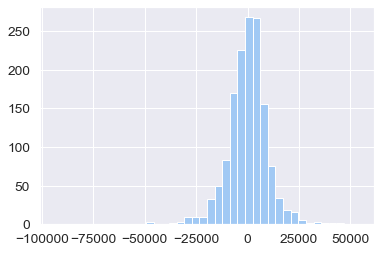

In [279]:
plt.hist(x-r, bins=40)